# Libraries

In [287]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import deque
import datetime as dt
import mplfinance 
from renkodf import Renko
from scipy.signal import lfilter
import fx # personal functions
# import MetaTrader5 as mt5

In [2]:
use_full_data = False

# Gathering Data

In [3]:
# collect the actual data from csv file
# filename = "C:/Users/WilliamFetzner/Documents/Trading/DAT_XLSX_EURUSD_M1_2023.xlsx"
if use_full_data:
    # exported from tickstory
    filepath = "C:/Users/WilliamFetzner/Documents/Trading/"
    tickstory_csvs = ["EURUSD_11_15_22_to_11_14_23.csv", "3mo_EURUSD.csv", "EURUSD_2_13_to_3_6.csv", 
                      "EURUSD_3_6_to_3_8_24.csv", "EURUSD_3_8_to_3_12_24.csv", "EURUSD_3_12_to_3_22_24.csv"]
    df = pd.DataFrame()
    for df_name in tickstory_csvs:
        df_new = pd.read_csv(filepath + df_name)
        print(len(df_new))
        df = pd.concat([df, df_new], ignore_index=True)


In [4]:
if use_full_data:    
    df = df.reset_index(drop=True)
    # drop any duplicate rows
    df = df.drop_duplicates()
    df.tail(10)


In [5]:
if use_full_data: 
    # convert date to datetime
    df['datetime'] = pd.to_datetime(df['Timestamp'], format='%Y%m%d %H:%M:%S:%f')
    # rename bid price to close
    df.rename(columns={'Bid price':'close'}, inplace=True)
    df_ready = df.set_index('datetime')
    # adjust the datetime 7 hrs ahead to match market time
    df_ready.index = df_ready.index + pd.Timedelta(hours=7)
    # df_tick_ready_2024 = df_ready['2024-01-01':'2024-02-13']
    # df_full['datetime'] = pd.to_datetime(df_full['date'] + ' ' + df_full['time'], format='%Y.%m.%d %H:%M')
    # filter the data to just 2024
    # df_full_2024 = fx.prep_data(df_full, 2024)
    # ohlc = fx.prep_data(df, 2024)

In [6]:
if use_full_data:     
    ohlc = df_ready[['close']]
    ohlc

# Getting Data Ready

# Exploratory Data Analysis

In [7]:
# ohlc.open.count()
# 1819/322638 old data
# 0.5% of the time it skips minutes
# and 100 of those it was skipping 2 hrs

# 89/371342
# 0.02% of the time it skips minutes
# and the largest range of skips is 3-28 minutes 
# for an avg of 7 minutes


In [8]:

# # find the difference in minutes between each row
# ohlc['diff'] = ohlc.index.to_series().diff().dt.total_seconds().div(60, fill_value=0)
# # find the difference in days between each row, place a 0 if it is the same day
# ohlc['diff_day'] = ohlc.index.to_series().diff().dt.days.fillna(0)
# # filter to where the diff is > 1 but the diff_day is 0
# ohlc_fil = ohlc.loc[(ohlc['diff'] > 1) & (ohlc['diff_day'] == 0)]
# # sort ohlc_fil by the diff column
# ohlc_fil = ohlc_fil.sort_values(by=['diff'], ascending=False)
# ohlc_fil.head(90)
# # find the avg of diff
# ohlc_fil['diff'].mean()


In [9]:
# drop 2023-12-26
# ohlc_fil = ohlc_fil.drop(ohlc_fil.loc['2023-12-26'].index)
# ohlc_fil

In [10]:
# # graph the index on the x axis and the diff on the y axis
# plt.scatter(ohlc_fil.index, ohlc_fil['diff'])
# # increase the size of the plot
# plt.gcf().set_size_inches(20, 10)
# plt.show()

In [11]:
# # find the count distinct of diff per month
# ohlc_fil['diff'].resample('ME').nunique()

In [12]:
# filter ohlc to be between march 23rd 12:00 and march 23rd 19:00
# ohlc_march_23 = ohlc.loc['2023-03-23 14:00':'2023-03-23 18:00']
# ohlc_march_23

## Nova Optimized Parameters

In [13]:
# # Renko variable
# brick_size = 0.00007

# # psar variables
# start = 0.139862
# increment = 0.139862
# maximum = 0.451

# # impulse variables
# lengthMA = 10
# lengthSignal = 8

## MSolutions Optimized Parameters

In [14]:
# # Renko variable
# brick_size = 0.00091

# # psar variables
# start = 0.0385
# increment = 0.0385
# maximum = 0.34499

# # impulse variables
# lengthMA = 51
# lengthSignal = 31

## Renko charts (from tick data)

In [15]:
if use_full_data:
    # brick_size_list = np.arange(0.0003, 0.00101, 0.00001)
    # # Renko variable
    # for brick_size in brick_size_list:
    #     # brick_size = 0.0005
    #     # create a renko chart from the ohlc_dec_1 dataframe
    #     r_full = Renko(ohlc, brick_size=brick_size)
    #     # create a new dataframe from the renko features
    #     renko_full_data = r_full.renko_df()
    #     # multiply brick_size by 10,000 to get a whole number
    #     brick_size_str = str(int(brick_size*100000))
    #     # save renko to csv
    #     renko_full_data.to_csv(f'./brick_size_variations/renko_full_data_{brick_size_str}.csv')
    brick_size = 0.00081
    # create a renko chart from the ohlc_dec_1 dataframe
    r_full = Renko(ohlc, brick_size=brick_size)
    # create a new dataframe from the renko features
    renko_full_data = r_full.renko_df()
    # multiply brick_size by 10,000 to get a whole number
    brick_size_str = str(int(brick_size*100000))
    # save renko to csv
    # renko_full_data.to_csv(f'./brick_size_variations/renko_full_data_{brick_size_str}.csv')
    renko_full_data.to_csv(f'renko_full_data_{brick_size_str}.csv')

# Start Here with Renko data

## Parameters

In [624]:
# Renko variable
brick_size = 0.00081
# multiply brick_size by 10,000 to get a whole number
brick_size_str = str(int(brick_size*100000))

# sma variables
sma_length = 4
smoothing_sma = 4

# Lot Size
lot_size = 3
per_lot = 100000

# pyramid
pyramid_size = 4
pyramid_bool = False

# stop loss
stop_loss = brick_size*2

# take profit
take_profit_size = brick_size*4

# Commissions
nova_commission = lot_size * -3
msolutions_commission = lot_size * -5

# starting balance
balance = 200000

# base currency rate
base_currency_rate = 0.045 # EUR
quote_currency_rate = 0.055 # USD

In [625]:
# read in the renko data
# renko_full_data = pd.read_csv(f'./brick_size_variations/renko_full_data_{brick_size_str}.csv')
renko_full_data = pd.read_csv(f'renko_full_data_{brick_size_str}.csv')
print(f'renko_full_data_{brick_size_str}.csv')
# convert date to datetime
renko_full_data['datetime'] = pd.to_datetime(renko_full_data['datetime'], format='%Y-%m-%d %H:%M:%S.%f')
renko_full_data = renko_full_data.set_index('datetime')

renko_full_data_81.csv


In [626]:
renko_full_data

,open,high,low,close,volume
datetime,,,,,
2022-11-15 08:13:02.507,1.03275,1.03356,1.03121,1.03356,25883.0
2022-11-15 08:56:15.116,1.03356,1.03437,1.03275,1.03437,4180.0
2022-11-15 09:20:17.255,1.03437,1.03518,1.03366,1.03518,3965.0
2022-11-15 09:23:26.075,1.03518,1.03599,1.03506,1.03599,732.0
2022-11-15 09:24:17.423,1.03599,1.03680,1.03599,1.03680,289.0
...,...,...,...,...,...
2024-03-22 05:36:47.442,1.08540,1.08566,1.08459,1.08459,3139.0
2024-03-22 06:11:00.244,1.08459,1.08459,1.08378,1.08378,1350.0
2024-03-22 09:41:23.913,1.08378,1.08419,1.08297,1.08297,6451.0


## Entry conditions

In [627]:
# calculate the sma of the open high low, close / 4 for 3 periods
renko_full_data['ohlc4'] = (renko_full_data['close'] + renko_full_data['open'] + renko_full_data['high'] + renko_full_data['low']) / 4
renko_full_data['sma'] = renko_full_data['ohlc4'].rolling(window=sma_length).mean()
# calculate the sma of sma3 for 3 periods
renko_full_data['smoothing_sma'] = renko_full_data['sma'].rolling(window=smoothing_sma).mean()
# find the difference between sma and smoothing_sma
renko_full_data['sma_diff'] = renko_full_data['sma'] - renko_full_data['smoothing_sma']
# find the sign of the sma_diff
renko_full_data['sma_sign'] = np.sign(renko_full_data['sma_diff'])
# find where the sma_sign changes from 1 to -1 or -1 to 1 or from 1
renko_full_data['sma_crossover'] = np.where((renko_full_data['sma_sign'] == 1) & (renko_full_data['sma_sign'].shift(1) == -1), 1, 
                                np.where((renko_full_data['sma_sign'] == -1) & (renko_full_data['sma_sign'].shift(1) == 1), -1, 
                                np.where((renko_full_data['sma_sign'] == -1) & (renko_full_data['sma_sign'].shift(1) == 0) & (renko_full_data['sma_sign'].shift(2) == 1), -1,
                                np.where((renko_full_data['sma_sign'] == 1) & (renko_full_data['sma_sign'].shift(1) == 0) & (renko_full_data['sma_sign'].shift(2) == -1), 1, 0))))
# when sma_crossover is 1 then buy, when sma_crossover is -1 then sell
renko_full_data['sma_signal'] = np.where(renko_full_data['sma_crossover'] == 1, 'buy',
                                np.where(renko_full_data['sma_crossover'] == -1, 'sell', ''))
renko_full_data

,open,high,low,close,volume,ohlc4,sma,smoothing_sma,sma_diff,sma_sign,sma_crossover,sma_signal
datetime,,,,,,,,,,,,
2022-11-15 08:13:02.507,1.03275,1.03356,1.03121,1.03356,25883.0,1.032770,NaN,NaN,NaN,NaN,0,
2022-11-15 08:56:15.116,1.03356,1.03437,1.03275,1.03437,4180.0,1.033762,NaN,NaN,NaN,NaN,0,
2022-11-15 09:20:17.255,1.03437,1.03518,1.03366,1.03518,3965.0,1.034597,NaN,NaN,NaN,NaN,0,
2022-11-15 09:23:26.075,1.03518,1.03599,1.03506,1.03599,732.0,1.035555,1.034171,NaN,NaN,NaN,0,
2022-11-15 09:24:17.423,1.03599,1.03680,1.03599,1.03680,289.0,1.036395,1.035077,NaN,NaN,NaN,0,
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-22 05:36:47.442,1.08540,1.08566,1.08459,1.08459,3139.0,1.085060,1.086302,1.087518,-0.001215,-1.0,0,
2024-03-22 06:11:00.244,1.08459,1.08459,1.08378,1.08378,1350.0,1.084185,1.085472,1.086704,-0.001232,-1.0,0,
2024-03-22 09:41:23.913,1.08378,1.08419,1.08297,1.08297,6451.0,1.083477,1.084668,1.085889,-0.001221,-1.0,0,


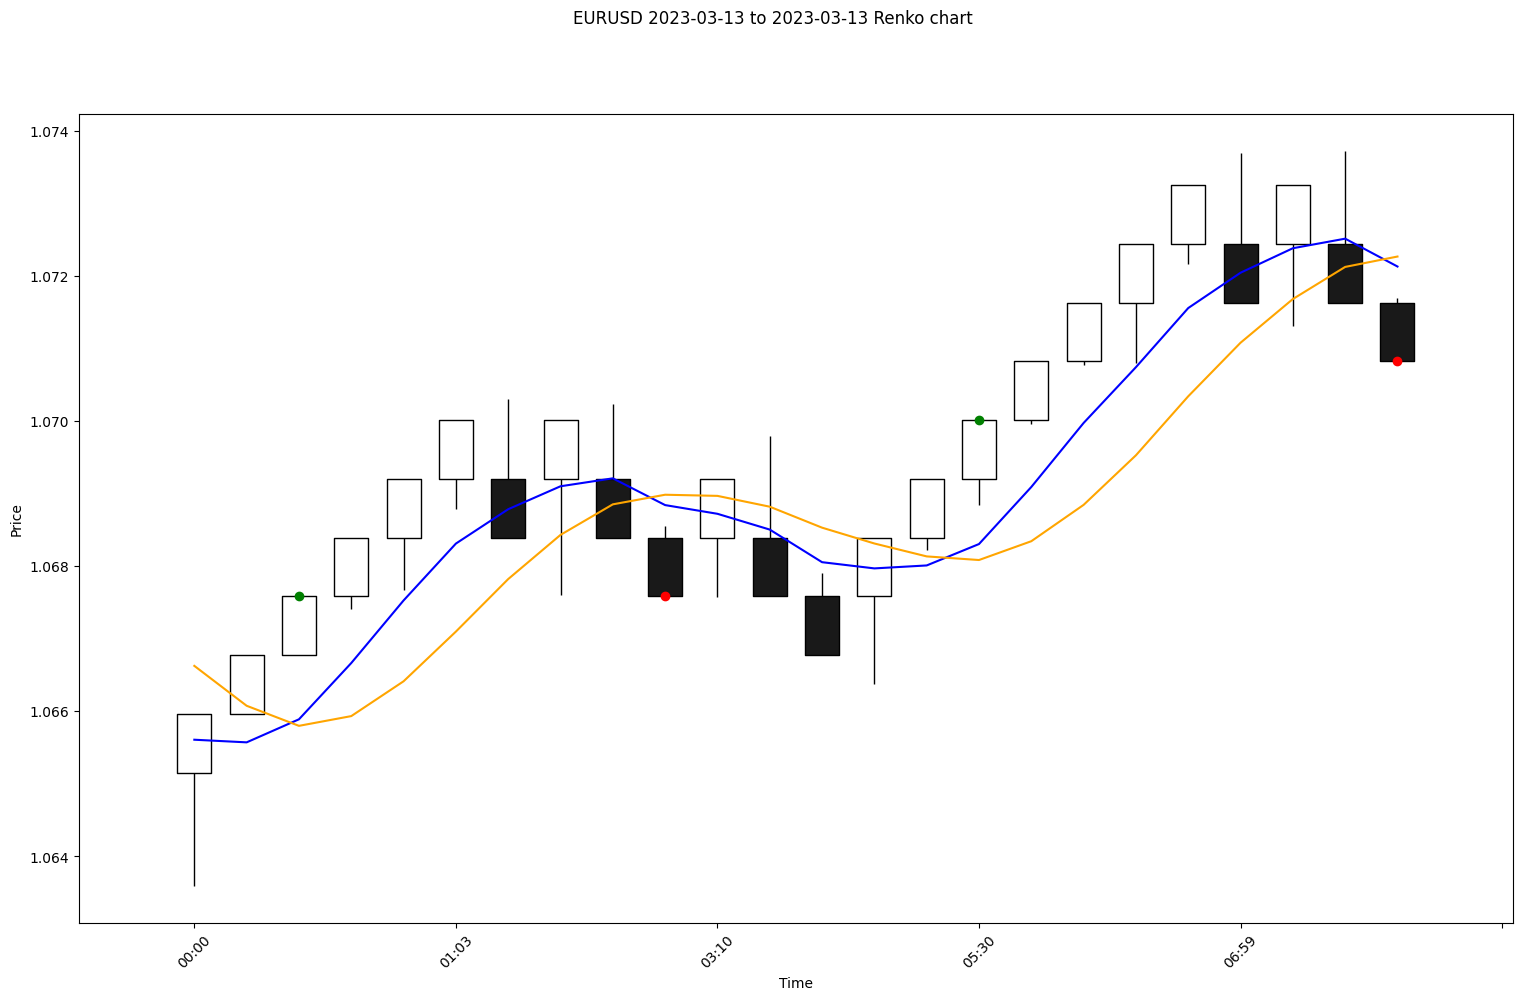

In [628]:
# filter to where the date and time is between 2024-03-07 16:36:00 and 2024.03.08 12:30:00
renko_full_data_select_day = renko_full_data.loc['2023-03-13 00:00:00':'2023-03-13 12:00:00']
# impulse_graph(renko_full_data_select_day, 'md', 'sb')
# plot the renko chart
fig, ax = plt.subplots()
mplfinance.plot(renko_full_data_select_day, type='candle', ax=ax, volume=False, show_nontrading=False)
renko_full_data_select_day_reset = renko_full_data_select_day.reset_index()
# add the sma and smoothing_sma to the chart
ax.plot(renko_full_data_select_day_reset.index, renko_full_data_select_day['sma'], label='SMA', color='blue')
ax.plot(renko_full_data_select_day_reset.index, renko_full_data_select_day['smoothing_sma'], label='SmoothingSMA', color='orange')
# add a column to renko_full_data_select_day_reset that copies the close price when sma_crossover is 1 or -1
renko_full_data_select_day_reset['sma_crossover_price_buy'] = np.where(renko_full_data_select_day['sma_crossover'] == 1, renko_full_data_select_day['close'], np.nan)
renko_full_data_select_day_reset['sma_crossover_price_sell'] = np.where(renko_full_data_select_day['sma_crossover'] == -1, renko_full_data_select_day['close'], np.nan)
# add a dot to the chart with the sma_crossover is 1 or -1 and color it green or red
ax.scatter(renko_full_data_select_day_reset.index, renko_full_data_select_day_reset['sma_crossover_price_buy'], color='green', marker='o', label='Buy', zorder=5)
ax.scatter(renko_full_data_select_day_reset.index, renko_full_data_select_day_reset['sma_crossover_price_sell'], color='red', marker='o', label='Sell', zorder=5)
ax.set_xlabel('Time')
ax.set_ylabel('Price')
# find the date of the first and last index
first_date = renko_full_data_select_day_reset['datetime'].iloc[0]
last_date = renko_full_data_select_day_reset['datetime'].iloc[-1]
fig.suptitle(f'EURUSD {first_date.date()} to {last_date.date()} Renko chart')
# increase the size of the chart
fig.set_size_inches(18.5, 10.5)

plt.show()

In [629]:
renko_full_data_select_day

,open,high,low,close,volume,ohlc4,sma,smoothing_sma,sma_diff,sma_sign,sma_crossover,sma_signal
datetime,,,,,,,,,,,,
2023-03-13 00:00:00.017,1.06515,1.06596,1.06359,1.06596,23640.0,1.065165,1.065604,1.066622,-0.001018,-1.0,0,
2023-03-13 00:00:00.017,1.06596,1.06677,1.06596,1.06677,1.0,1.066365,1.065568,1.066072,-0.000504,-1.0,0,
2023-03-13 00:00:00.017,1.06677,1.06758,1.06677,1.06758,1.0,1.067175,1.065886,1.065796,0.000090,1.0,1,buy
2023-03-13 00:17:40.347,1.06758,1.06839,1.06740,1.06839,683.0,1.067940,1.066661,1.065930,0.000731,1.0,0,
2023-03-13 00:59:28.195,1.06839,1.06920,1.06767,1.06920,528.0,1.068615,1.067524,1.066410,0.001114,1.0,0,
2023-03-13 01:03:40.712,1.06920,1.07001,1.06878,1.07001,377.0,1.069500,1.068307,1.067095,0.001213,1.0,0,
2023-03-13 01:19:51.498,1.06920,1.07030,1.06839,1.06839,1167.0,1.069070,1.068781,1.067818,0.000963,1.0,0,
2023-03-13 02:10:03.878,1.06920,1.07001,1.06760,1.07001,7157.0,1.069205,1.069097,1.068427,0.000670,1.0,0,
2023-03-13 02:55:30.390,1.06920,1.07023,1.06839,1.06839,8072.0,1.069052,1.069207,1.068848,0.000359,1.0,0,


In [630]:
fx.cum_count(renko_full_data_select_day)
fx.add_tp_sl(renko_full_data_select_day, take_profit_size, stop_loss)

c:\Users\WilliamFetzner\Documents\Trading\fx.py:199: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['position_count'] = np.where(df['sma_crossover'] == 1, 1, np.where(df['sma_crossover'] == -1, 1,0))
c:\Users\WilliamFetzner\Documents\Trading\fx.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cum_position_count'] = df['position_count'].cumsum()
c:\Users\WilliamFetzner\Documents\Trading\fx.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

,open,high,low,close,volume,ohlc4,sma,smoothing_sma,sma_diff,sma_sign,sma_crossover,sma_signal,position_count,cum_position_count,take_profit,stop_loss
datetime,,,,,,,,,,,,,,,,
2023-03-13 00:00:00.017,1.06515,1.06596,1.06359,1.06596,23640.0,1.065165,1.065604,1.066622,-0.001018,-1.0,0,,0,0,NaN,NaN
2023-03-13 00:00:00.017,1.06596,1.06677,1.06596,1.06677,1.0,1.066365,1.065568,1.066072,-0.000504,-1.0,0,,0,0,NaN,NaN
2023-03-13 00:00:00.017,1.06677,1.06758,1.06677,1.06758,1.0,1.067175,1.065886,1.065796,0.000090,1.0,1,buy,1,1,1.07001,1.06515
2023-03-13 00:17:40.347,1.06758,1.06839,1.06740,1.06839,683.0,1.067940,1.066661,1.065930,0.000731,1.0,0,,0,1,NaN,NaN
2023-03-13 00:59:28.195,1.06839,1.06920,1.06767,1.06920,528.0,1.068615,1.067524,1.066410,0.001114,1.0,0,,0,1,NaN,NaN
2023-03-13 01:03:40.712,1.06920,1.07001,1.06878,1.07001,377.0,1.069500,1.068307,1.067095,0.001213,1.0,0,,0,1,NaN,NaN
2023-03-13 01:19:51.498,1.06920,1.07030,1.06839,1.06839,1167.0,1.069070,1.068781,1.067818,0.000963,1.0,0,,0,1,NaN,NaN
2023-03-13 02:10:03.878,1.06920,1.07001,1.06760,1.07001,7157.0,1.069205,1.069097,1.068427,0.000670,1.0,0,,0,1,NaN,NaN
2023-03-13 02:55:30.390,1.06920,1.07023,1.06839,1.06839,8072.0,1.069052,1.069207,1.068848,0.000359,1.0,0,,0,1,NaN,NaN


In [631]:
# bring in the spread data
spread = pd.read_csv('spread_results_03_11_24_03_12_24.csv', index_col=0)

In [632]:
profit_df_select_day = pd.DataFrame() #columns=['cum_position_count', 'direction', 'entry_price', 'exit_price', 'first_TP_hit', 'profit']
# calculate the profit for each position by first grouping by each position and finding the entry price
profit_df_select_day['entry_price'] = renko_full_data_select_day.groupby('cum_position_count')['close'].first()
# separate out the datetime column
renko_full_data_select_day['datetime'] = renko_full_data_select_day.index
profit_df_select_day['entry_time'] = renko_full_data_select_day.groupby('cum_position_count')['datetime'].first()
profit_df_select_day['exit_time'] = renko_full_data_select_day.groupby('cum_position_count')['datetime'].last()
# # determine the exit price
profit_df_select_day['exit_price'] = renko_full_data_select_day.groupby('cum_position_count')['close'].last()

# # what was the direction, buy or short?
profit_df_select_day['direction'] = renko_full_data_select_day.groupby('cum_position_count')['sma_signal'].first()
# what was the brick color when the position was entered?
# profit_df_select_day['brick_color'] = renko_full_data_select_day.groupby('cum_position_count')['brick_color'].first()
# profit_df_select_day['direction'] = profit_df_select_day['direction'].str.split('+').str[1]

# what if I didn't take the first TP?
profit_df_select_day['Nova_profit_initial'] = np.where((profit_df_select_day['direction'].str.strip() == 'buy'),
                                            ((profit_df_select_day['exit_price'] + spread.loc['Close Spread Buy', 'Nova']) - (profit_df_select_day['entry_price'] + 
                                                                                                                              spread.loc['Spread Buy', 'Nova']))
                                                     * per_lot * (lot_size), 
                                            np.where((profit_df_select_day['direction'].str.strip() == 'sell'),
                                                    ((profit_df_select_day['entry_price'] + spread.loc['Spread Sell', 'Nova']) - (profit_df_select_day['exit_price'] +
                                                                                                                                   spread.loc['Close Spread Sell', 'Nova']))
                                                    * per_lot * (lot_size), np.nan))
profit_df_select_day['MSolutions_profit_initial'] = np.where((profit_df_select_day['direction'].str.strip() == 'buy'),
                                            ((profit_df_select_day['exit_price'] + spread.loc['Close Spread Buy', 'MSolutions']) - (profit_df_select_day['entry_price'] + 
                                                                                                                                    spread.loc['Spread Buy', 'MSolutions']))
                                            * per_lot * (lot_size), 
                                            np.where((profit_df_select_day['direction'].str.strip() == 'sell'),
                                                    ((profit_df_select_day['entry_price'] + spread.loc['Spread Sell', 'MSolutions']) - (profit_df_select_day['exit_price'] + 
                                                                                                                                        spread.loc['Close Spread Sell', 'MSolutions']))
                                                    * per_lot * (lot_size), np.nan))
profit_df_select_day = fx.add_swap_rates(profit_df_select_day, base_currency_rate, quote_currency_rate, lots=lot_size)
profit_df_select_day['nova_profit'] = profit_df_select_day['Nova_profit_initial'] + nova_commission + profit_df_select_day['swap_rate']
profit_df_select_day['msolutions_profit'] = profit_df_select_day['MSolutions_profit_initial'] + msolutions_commission + profit_df_select_day['swap_rate']

C:\Users\WilliamFetzner\AppData\Local\Temp\ipykernel_10396\2492178391.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  renko_full_data_select_day['datetime'] = renko_full_data_select_day.index


In [633]:
profit_df_select_day

,entry_price,entry_time,exit_time,exit_price,direction,Nova_profit_initial,MSolutions_profit_initial,swap,swap_rate,nova_profit,msolutions_profit
cum_position_count,,,,,,,,,,,
0,1.06596,2023-03-13 00:00:00.017,2023-03-13 00:00:00.017,1.06677,,NaN,NaN,0,0.0,NaN,NaN
1,1.06758,2023-03-13 00:00:00.017,2023-03-13 02:55:30.390,1.06839,buy,192.0,181.5,0,0.0,183.0,166.5
2,1.06758,2023-03-13 03:01:33.592,2023-03-13 05:25:13.517,1.06920,sell,-519.0,-543.0,0,0.0,-528.0,-558.0
3,1.07001,2023-03-13 05:30:12.631,2023-03-13 11:27:26.314,1.07163,buy,435.0,424.5,0,0.0,426.0,409.5
4,1.07082,2023-03-13 11:33:38.741,2023-03-13 11:33:38.741,1.07082,sell,-33.0,-57.0,0,0.0,-42.0,-72.0


In [634]:
# find the sum of nova_profit and msolutions_profit
nova_sum = profit_df_select_day['nova_profit'].sum()
msolutions_sum = profit_df_select_day['msolutions_profit'].sum()
print(f'Nova: {nova_sum}', f'MSolutions: {msolutions_sum}')

Nova: 38.99999999995841 MSolutions: -53.99999999996078


In [635]:
# find the max of renko_full_data.index
max_index = renko_full_data.index.max() - pd.Timedelta(days=1)
# filter to just the day in the max_index
renko_full_data_max_day = renko_full_data.loc[renko_full_data.index.date == max_index.date()]
# impulse_graph(renko_full_data_max_day, 'md', 'sb')

In [636]:
# # plot the renko chart
# fig, ax = plt.subplots()
# mplfinance.plot(renko_full_data_max_day, type='candle', ax=ax, volume=False, show_nontrading=False)
# renko_full_data_max_day_reset = renko_full_data_max_day.reset_index()
# # add the sma and smoothing_sma to the chart
# ax.plot(renko_full_data_max_day_reset.index, renko_full_data_max_day['sma'], label='SMA', color='blue')
# ax.plot(renko_full_data_max_day_reset.index, renko_full_data_max_day['smoothing_sma'], label='SmoothingSMA', color='orange')
# ax.set_xlabel('Time')
# ax.set_ylabel('Price')
# fig.suptitle(f'EURUSD {max_index.date()} Renko chart')
# # increase the size of the chart
# fig.set_size_inches(18.5, 10.5)

# plt.show()

In [637]:
# add a column to renko_full_data that will indicate the color of the renko brick based on the "open" and "close" columns of the renko_full_data dataframe, 
# if the open is greater than the close then the color is red, otherwise it is green
renko_full_data['brick_color'] = np.where(renko_full_data['open'] > renko_full_data['close'], 'red', 'green')

In [638]:
# add the day of the week to the dataframe
renko_full_data['day_of_week'] = renko_full_data.index.day_name()
# place a 1 in day_of_week_transition, if it is the last bar on Friday and the next bar is Sunday
renko_full_data['day_of_week_transition'] = np.where((renko_full_data['day_of_week'] == 'Friday') & 
                                                     ((renko_full_data['day_of_week'].shift(-1) == 'Sunday') | 
                                                      (renko_full_data['day_of_week'].shift(-1) == 'Monday') |
                                                      (renko_full_data['day_of_week'].shift(-1) == 'Tuesday')), 1, 0)

In [639]:
renko_full_data.columns

Index(['open', 'high', 'low', 'close', 'volume', 'ohlc4', 'sma',
       'smoothing_sma', 'sma_diff', 'sma_sign', 'sma_crossover', 'sma_signal',
       'brick_color', 'day_of_week', 'day_of_week_transition'],
      dtype='object')

In [640]:
# if the day_of_week_transition is 1 and the sma_signal is 1 then replace sma_signal with ''
renko_full_data['sma_signal'] = np.where((renko_full_data['day_of_week_transition'] == 1), 'exit', renko_full_data['sma_signal'])
# Forward fill 'exit' values up to the next 'buy' or 'sell'
mask = renko_full_data['sma_signal'].isin(['buy', 'sell'])
renko_full_data['sma_signal'] = renko_full_data['sma_signal'].where(mask | (renko_full_data['sma_signal'] == 'exit')).ffill()
renko_full_data

,open,high,low,close,volume,ohlc4,sma,smoothing_sma,sma_diff,sma_sign,sma_crossover,sma_signal,brick_color,day_of_week,day_of_week_transition
datetime,,,,,,,,,,,,,,,
2022-11-15 08:13:02.507,1.03275,1.03356,1.03121,1.03356,25883.0,1.032770,NaN,NaN,NaN,NaN,0,NaN,green,Tuesday,0
2022-11-15 08:56:15.116,1.03356,1.03437,1.03275,1.03437,4180.0,1.033762,NaN,NaN,NaN,NaN,0,NaN,green,Tuesday,0
2022-11-15 09:20:17.255,1.03437,1.03518,1.03366,1.03518,3965.0,1.034597,NaN,NaN,NaN,NaN,0,NaN,green,Tuesday,0
2022-11-15 09:23:26.075,1.03518,1.03599,1.03506,1.03599,732.0,1.035555,1.034171,NaN,NaN,NaN,0,NaN,green,Tuesday,0
2022-11-15 09:24:17.423,1.03599,1.03680,1.03599,1.03680,289.0,1.036395,1.035077,NaN,NaN,NaN,0,NaN,green,Tuesday,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-22 05:36:47.442,1.08540,1.08566,1.08459,1.08459,3139.0,1.085060,1.086302,1.087518,-0.001215,-1.0,0,sell,red,Friday,0
2024-03-22 06:11:00.244,1.08459,1.08459,1.08378,1.08378,1350.0,1.084185,1.085472,1.086704,-0.001232,-1.0,0,sell,red,Friday,0
2024-03-22 09:41:23.913,1.08378,1.08419,1.08297,1.08297,6451.0,1.083477,1.084668,1.085889,-0.001221,-1.0,0,sell,red,Friday,0


In [641]:
fx.add_tp_sl(renko_full_data, take_profit_size, stop_loss)
renko_full_data

,open,high,low,close,volume,ohlc4,sma,smoothing_sma,sma_diff,sma_sign,sma_crossover,sma_signal,brick_color,day_of_week,day_of_week_transition,take_profit,stop_loss
datetime,,,,,,,,,,,,,,,,,
2022-11-15 08:13:02.507,1.03275,1.03356,1.03121,1.03356,25883.0,1.032770,NaN,NaN,NaN,NaN,0,NaN,green,Tuesday,0,NaN,NaN
2022-11-15 08:56:15.116,1.03356,1.03437,1.03275,1.03437,4180.0,1.033762,NaN,NaN,NaN,NaN,0,NaN,green,Tuesday,0,NaN,NaN
2022-11-15 09:20:17.255,1.03437,1.03518,1.03366,1.03518,3965.0,1.034597,NaN,NaN,NaN,NaN,0,NaN,green,Tuesday,0,NaN,NaN
2022-11-15 09:23:26.075,1.03518,1.03599,1.03506,1.03599,732.0,1.035555,1.034171,NaN,NaN,NaN,0,NaN,green,Tuesday,0,NaN,NaN
2022-11-15 09:24:17.423,1.03599,1.03680,1.03599,1.03680,289.0,1.036395,1.035077,NaN,NaN,NaN,0,NaN,green,Tuesday,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-22 05:36:47.442,1.08540,1.08566,1.08459,1.08459,3139.0,1.085060,1.086302,1.087518,-0.001215,-1.0,0,sell,red,Friday,0,NaN,NaN
2024-03-22 06:11:00.244,1.08459,1.08459,1.08378,1.08378,1350.0,1.084185,1.085472,1.086704,-0.001232,-1.0,0,sell,red,Friday,0,NaN,NaN
2024-03-22 09:41:23.913,1.08378,1.08419,1.08297,1.08297,6451.0,1.083477,1.084668,1.085889,-0.001221,-1.0,0,sell,red,Friday,0,NaN,NaN


In [642]:
fx.cum_count(renko_full_data)

,open,high,low,close,volume,ohlc4,sma,smoothing_sma,sma_diff,sma_sign,sma_crossover,sma_signal,brick_color,day_of_week,day_of_week_transition,take_profit,stop_loss,position_count,cum_position_count
datetime,,,,,,,,,,,,,,,,,,,
2022-11-15 08:13:02.507,1.03275,1.03356,1.03121,1.03356,25883.0,1.032770,NaN,NaN,NaN,NaN,0,NaN,green,Tuesday,0,NaN,NaN,0,0
2022-11-15 08:56:15.116,1.03356,1.03437,1.03275,1.03437,4180.0,1.033762,NaN,NaN,NaN,NaN,0,NaN,green,Tuesday,0,NaN,NaN,0,0
2022-11-15 09:20:17.255,1.03437,1.03518,1.03366,1.03518,3965.0,1.034597,NaN,NaN,NaN,NaN,0,NaN,green,Tuesday,0,NaN,NaN,0,0
2022-11-15 09:23:26.075,1.03518,1.03599,1.03506,1.03599,732.0,1.035555,1.034171,NaN,NaN,NaN,0,NaN,green,Tuesday,0,NaN,NaN,0,0
2022-11-15 09:24:17.423,1.03599,1.03680,1.03599,1.03680,289.0,1.036395,1.035077,NaN,NaN,NaN,0,NaN,green,Tuesday,0,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-22 05:36:47.442,1.08540,1.08566,1.08459,1.08459,3139.0,1.085060,1.086302,1.087518,-0.001215,-1.0,0,sell,red,Friday,0,NaN,NaN,0,943
2024-03-22 06:11:00.244,1.08459,1.08459,1.08378,1.08378,1350.0,1.084185,1.085472,1.086704,-0.001232,-1.0,0,sell,red,Friday,0,NaN,NaN,0,943
2024-03-22 09:41:23.913,1.08378,1.08419,1.08297,1.08297,6451.0,1.083477,1.084668,1.085889,-0.001221,-1.0,0,sell,red,Friday,0,NaN,NaN,0,943


In [643]:
## finding out where the stoploss was hit, if stoploss is brick_size*2 and the sma_length and smoothing_length are 3 then the stoploss makes no difference because we are exiting anyways
## it is just good protection in case the order doesn't close correctly via the broker
# forward fill the stoploss
renko_full_data['stop_loss'] = renko_full_data['stop_loss'].ffill()
# determine if any stoploss is hit and if so create a new column called 'stop_loss_hit' and place a 1 in it
renko_full_data['stop_loss_hit'] = np.where((renko_full_data['sma_signal'] == 'buy') & (renko_full_data['low'] < renko_full_data['stop_loss']), 1, 
                                           np.where((renko_full_data['sma_signal'] == 'sell') & (renko_full_data['high'] > renko_full_data['stop_loss']), 1, 0))
stop_loss_hit_df = renko_full_data[renko_full_data['stop_loss_hit'] == 1]
# stop_loss_hit_df

In [644]:
#export stop_loss_hit_df to csv
# stop_loss_hit_df.to_csv('stop_loss_hit_df.csv')

In [645]:
# sma_0 = renko_full_data[renko_full_data['sma_sign'] == 0]
# get a list of the cum_position_count values
# cum_position_count_list = list(sma_0['cum_position_count'].dropna().unique())
# sma_0

In [646]:
# def sl_tp_exits(df):
#     changed = 0
#     # group by cum_position_count and forward fill the value in the first index of the 'stop_loss' column
#     df['stop_loss'] = df.groupby('cum_position_count')['stop_loss'].ffill()
#     df['take_profit'] = df.groupby('cum_position_count')['take_profit'].ffill()

#     # determine whether the exit should be sooner because the stop_loss was hit before the exit signal (look at the high/low of the brick)
#     df['exit_stop_loss'] = np.where((df['entry_signal'] == 'long') & (df['stop_loss'] > df['low']), 1,
#                                             np.where((df['entry_signal'] == 'short') & (df['stop_loss'] < df['high']), 1, 0))
#     df['exit_take_profit'] = np.where((df['entry_signal'] == 'long') & (df['take_profit'] < df['high']), 1,
#                                             np.where((df['entry_signal'] == 'short') & (df['take_profit'] > df['low']), 1, 0))
#     # if there is a 1 in exit_stop_loss or exit_take_profit then set changed to 1
#     if (df['exit_stop_loss'] == 1).any() or (df['exit_take_profit'] == 1).any():
#         # get the sum of exit_stop_loss and exit_take_profit
#         print(df.exit_stop_loss.sum(), df.exit_take_profit.sum())
#         changed = 1
#     df['exit_stop_loss'] = df.groupby('cum_position_count')['exit_stop_loss'].ffill()
#     df['exit_take_profit'] = df.groupby('cum_position_count')['exit_take_profit'].ffill()
#     # if entry signal isn't 'none' and exit_stop_loss or exit_take_profit is 1 then the entry signal should be 'none'
#     df['entry_signal'] = np.where(((df['entry_signal'] != 'none') & 
#                                                 ((df['exit_stop_loss'] == 1) | (df['exit_take_profit'] == 1))), 
#                                                 'none', 
#                                                 df['entry_signal'])
#     return df, changed

In [647]:
# add a column that will be the entry signal for the strategy to be when both impulse_signal and psar_signal are both 'buy' or 'short'
# renko_entry_added = add_entry_signal(renko_full_data, True, True)

# # if there was a change from 'none' to 'buy' or 'short' then that is an entry signal and replace the 'buy' or 'short' with 'entry + buy' or 'entry + short'
# add_entry_prefix(renko_entry_added)

# # add a stop loss column that will be the entry price +/- the brick size for when the entry signal is 'entry + buy' or 'entry + short'
# add_tp_sl(renko_entry_added, take_profit_size, stop_loss)

# # if the 'entry_signal' colummn goes from 'entry + short' or 'short' to 'none' then 'none' should be replaced with 'exit' in the entry_signal column
# renko_w_exits = add_exit_signal(renko_w_stop_loss)

# # add cumulative count columns
# renko_cum_count = cum_count(renko_w_exits)

# # see if exits should be sooner with stop_loss and take_profit then repeat above steps
# df_changed = 1
# iteration = 0
# while df_changed == 1:
#     renko_entry_added, df_changed = sl_tp_exits(renko_entry_added)
#     # add a column that will be the entry signal for the strategy to be when both impulse_signal and psar_signal are both 'buy' or 'short'
#     renko_entry_added = add_entry_signal(renko_entry_added, True, True)

#     # if there was a change from 'none' to 'buy' or 'short' then that is an entry signal and replace the 'buy' or 'short' with 'entry + buy' or 'entry + short'
#     renko_entry_added = add_entry_prefix(renko_entry_added)

#     # add a stop loss column that will be the entry price +/- the brick size for when the entry signal is 'entry + buy' or 'entry + short'
#     renko_entry_added = add_tp_sl(renko_entry_added, take_profit_size, stop_loss)

#     # if the 'entry_signal' colummn goes from 'entry + short' or 'short' to 'none' then 'none' should be replaced with 'exit' in the entry_signal column
#     renko_entry_added = add_exit_signal(renko_entry_added)

#     # add cumulative count columns
#     renko_entry_added = cum_count(renko_entry_added)
    
#     iteration += 1
    
#     print('iteration:', iteration)


In [648]:
# # add a new column to the dataframe that is 'red' if the psar is above the close and 'green' if the psar is below the close
# renko_full_data['color'] = np.where(renko_full_data['psar'] > renko_full_data['close'], 'red', 'green')
# renko_df_one_day = renko_full_data.loc[renko_full_data.index.date == dt.datetime(2024, 2, 5).date()]
# # reset the index of the dataframe
# # psar_one_day = renko_df_one_day.reset_index()
# # make a column of just the count
# renko_df_one_day['count'] = range(1, len(renko_df_one_day.open) + 1)
# # renko_df_one_day

In [649]:
# renko_df_one_day.loc[:,['high','open', 'close', 'low', 'psar', 'md', 'sb', 'psar_signal', 'impulse_signal']].head(25)

In [650]:
# # plot the renko chart
# fig, ax = plt.subplots()
# mplfinance.plot(renko_df_one_day, type='candle', ax=ax, volume=False, show_nontrading=False)
# # add the psar scatterplot to the chart
# plt.scatter(renko_df_one_day['count'], renko_df_one_day['psar'], color=renko_df_one_day['color'], lw=0.5, label='PSAR')
# ax.set_xlabel('Time')
# ax.set_ylabel('Price')
# fig.suptitle('EURUSD 2/5/2023 Renko chart w/ PSAR')
# # increase the size of the chart
# fig.set_size_inches(18.5, 10.5)

# plt.show()

In [651]:
# impulse_graph(renko_df_one_day, 'md', 'sb')

In [652]:
# maybe implement this later - right now, let's keep the SL where it is

# # if first_TP_hit is 1 then the stop_loss should be set to the entry close price for that position so we need to group by the cum_position_count
# renko_full_data['stop_loss'] = np.where(renko_full_data['first_TP_hit'] == 1, renko_full_data.groupby('cum_position_count')['close'].transform('first'), renko_full_data['stop_loss'])
# # drop 'stop_loss_test'
# renko_full_data.drop(columns=['stop_loss_test'], inplace=True)
# redetermine whether the new stop_loss was hit after we took the first TP
# renko_full_data['exit_stop_loss'] = np.where((renko_full_data['entry_signal'] == 'buy') & (renko_full_data['stop_loss'] > renko_full_data['low']), 1,
#                                         np.where((renko_full_data['entry_signal'] == 'short') & (renko_full_data['stop_loss'] < renko_full_data['high']), 1, 0))
# renko_full_data.loc[renko_full_data['exit_stop_loss'] == 1]
# happens 908/2371 = 40% of the time

In [653]:
renko_full_data.loc[:,['high','open', 'close', 'low', 'sma_signal', 'stop_loss', 'cum_position_count']].tail(25)

,high,open,close,low,sma_signal,stop_loss,cum_position_count
datetime,,,,,,,
2024-03-20 21:38:17.585,1.08864,1.08783,1.08864,1.08659,buy,1.08459,942
2024-03-20 21:42:12.769,1.08945,1.08864,1.08945,1.08819,buy,1.08459,942
2024-03-20 21:45:25.345,1.09026,1.08945,1.09026,1.08879,buy,1.08459,942
2024-03-20 21:52:33.744,1.09107,1.09026,1.09107,1.09002,buy,1.08459,942
2024-03-20 22:31:33.807,1.09188,1.09107,1.09188,1.09018,buy,1.08459,942
2024-03-21 01:11:02.313,1.09269,1.09188,1.09269,1.09158,buy,1.08459,942
2024-03-21 02:25:13.767,1.09350,1.09269,1.09350,1.09269,buy,1.08459,942
2024-03-21 11:15:00.216,1.09426,1.09269,1.09188,1.09188,buy,1.08459,942
2024-03-21 11:15:00.269,1.09188,1.09188,1.09107,1.09107,buy,1.08459,942


## Find the P/L

In [654]:
spread

,MSolutions,Nova
Spread Buy,0.000095,0.00007
Spread Sell,-0.000110,-0.00003
Close Spread Buy,-0.000110,-0.00010
Close Spread Sell,0.000080,0.00008


In [655]:
profit_df = pd.DataFrame() #columns=['cum_position_count', 'direction', 'entry_price', 'exit_price', 'first_TP_hit', 'profit']
# calculate the profit for each position by first grouping by each position and finding the entry price
profit_df['entry_price'] = renko_full_data.groupby('cum_position_count')['close'].first()
# separate out the datetime column
renko_full_data['datetime'] = renko_full_data.index
profit_df['entry_time'] = renko_full_data.groupby('cum_position_count')['datetime'].first()
profit_df['exit_time'] = renko_full_data.groupby('cum_position_count')['datetime'].last()
# # determine the exit price
profit_df['exit_price'] = renko_full_data.groupby('cum_position_count')['close'].last()

# # what was the direction, buy or short?
profit_df['direction'] = renko_full_data.groupby('cum_position_count')['sma_signal'].first()
# what was the brick color when the position was entered?
profit_df['brick_color'] = renko_full_data.groupby('cum_position_count')['brick_color'].first()
# profit_df['direction'] = profit_df['direction'].str.split('+').str[1]

# what if I didn't take the first TP?
profit_df['Nova_profit_initial'] = np.where((profit_df['direction'].str.strip() == 'buy'),
                                            ((profit_df['exit_price'] + spread.loc['Close Spread Buy', 'Nova']) - (profit_df['entry_price'] + spread.loc['Spread Buy', 'Nova']))
                                            * per_lot * (lot_size), 
                                            np.where((profit_df['direction'].str.strip() == 'sell'),
                                                    ((profit_df['entry_price'] + spread.loc['Spread Sell', 'Nova']) - (profit_df['exit_price'] + spread.loc['Close Spread Sell', 'Nova']))
                                                    * per_lot * (lot_size), np.nan))
profit_df['MSolutions_profit_initial'] = np.where((profit_df['direction'].str.strip() == 'buy'),
                                            ((profit_df['exit_price'] + spread.loc['Close Spread Buy', 'MSolutions']) - (profit_df['entry_price'] + spread.loc['Spread Buy', 'MSolutions']))
                                            * per_lot * (lot_size), 
                                            np.where((profit_df['direction'].str.strip() == 'sell'),
                                                    ((profit_df['entry_price'] + spread.loc['Spread Sell', 'MSolutions']) - (profit_df['exit_price'] + spread.loc['Close Spread Sell', 'MSolutions']))
                                                    * per_lot * (lot_size), np.nan))

In [656]:
# create 2 new columns for spread exits for nova and msolutions
profit_df['nova_spread_exit_price'] = np.where((profit_df['direction'].str.strip() == 'buy'), profit_df['exit_price'] + spread.loc['Close Spread Buy', 'Nova'],
                                            np.where((profit_df['direction'].str.strip() == 'sell'), profit_df['exit_price'] + spread.loc['Close Spread Sell', 'Nova'], np.nan))
profit_df['msolutions_spread_exit_price'] = np.where((profit_df['direction'].str.strip() == 'buy'), profit_df['exit_price'] + spread.loc['Close Spread Buy', 'MSolutions'],
                                                np.where((profit_df['direction'].str.strip() == 'sell'), profit_df['exit_price'] + spread.loc['Close Spread Sell', 'MSolutions'], np.nan))
# create 2 new columns for spread entries for nova and msolutions
profit_df['nova_spread_entry_price'] = np.where((profit_df['direction'].str.strip() == 'buy'), profit_df['entry_price'] + spread.loc['Spread Buy', 'Nova'],
                                            np.where((profit_df['direction'].str.strip() == 'sell'), profit_df['entry_price'] + spread.loc['Spread Sell', 'Nova'], np.nan))
profit_df['msolutions_spread_entry_price'] = np.where((profit_df['direction'].str.strip() == 'buy'), profit_df['entry_price'] + spread.loc['Spread Buy', 'MSolutions'],
                                                np.where((profit_df['direction'].str.strip() == 'sell'), profit_df['entry_price'] + spread.loc['Spread Sell', 'MSolutions'], np.nan))


### Swap Rates

In [657]:
# find the positions where the period in between the entry_time and exit_time include 5:00 pm 
profit_df = fx.add_swap_rates(profit_df, base_currency_rate, quote_currency_rate, lots=lot_size)
profit_df

,entry_price,entry_time,exit_time,exit_price,direction,brick_color,Nova_profit_initial,MSolutions_profit_initial,nova_spread_exit_price,msolutions_spread_exit_price,nova_spread_entry_price,msolutions_spread_entry_price,swap,swap_rate
cum_position_count,,,,,,,,,,,,,,
0,1.03356,2022-11-15 08:13:02.507,2022-11-15 10:37:09.822,1.04004,None,green,NaN,NaN,NaN,NaN,NaN,NaN,0,0.000000
1,1.03923,2022-11-15 11:23:05.995,2022-11-15 12:31:05.758,1.04166,sell,red,-762.0,-786.0,1.04174,1.04174,1.03920,1.039120,0,0.000000
2,1.04247,2022-11-15 12:37:55.531,2022-11-15 14:03:31.670,1.04085,buy,green,-537.0,-547.5,1.04075,1.04074,1.04254,1.042565,0,0.000000
3,1.04004,2022-11-15 14:15:25.349,2022-11-15 15:30:05.830,1.04166,sell,red,-519.0,-543.0,1.04174,1.04174,1.04001,1.039930,0,0.000000
4,1.04247,2022-11-15 15:30:15.262,2022-11-15 15:41:58.165,1.04490,buy,green,678.0,667.5,1.04480,1.04479,1.04254,1.042565,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,1.08702,2024-03-18 19:25:57.817,2024-03-19 17:15:53.642,1.08621,sell,red,210.0,186.0,1.08629,1.08629,1.08699,1.086910,0,0.000000
940,1.08702,2024-03-20 06:13:30.844,2024-03-20 12:07:58.310,1.08459,buy,green,-780.0,-790.5,1.08449,1.08448,1.08709,1.087115,0,0.000000
941,1.08378,2024-03-20 12:54:02.219,2024-03-20 20:10:54.681,1.08621,sell,red,-762.0,-786.0,1.08629,1.08629,1.08375,1.083670,1,7.566841


In [658]:
# pass_through_0 = profit_df[profit_df.index.isin(cum_position_count_list)]

# # how many pass_through_0 are negative?
# print(len(pass_through_0[pass_through_0['profit'] > 0].index), len(pass_through_0.index))

In [659]:
# # if the brick color is red and direction is buy or if the brick color is green and the direction is sell then mark brick_color_opposite as 1
# profit_df['brick_color_opposite'] = np.where((profit_df['brick_color'] == 'red') & (profit_df['direction'] == 'buy'), 1,
#                                             np.where((profit_df['brick_color'] == 'green') & (profit_df['direction'] == 'sell'), 1, 0))
# # find the sum of brick_color_opposite
# entries_w_opposite_brick = profit_df['brick_color_opposite'].sum()
# # find out how many entries had an opposite brick color and were profitable
# entries_w_opposite_brick_profitable = len(profit_df[(profit_df['brick_color_opposite'] == 1) & (profit_df['profit'] > 0)].index)

# print('entries_w_opposite_brick: ', entries_w_opposite_brick, 'entries_w_opposite_brick_profitable: ', entries_w_opposite_brick_profitable,
#       '% profitable: ', entries_w_opposite_brick_profitable/entries_w_opposite_brick)


In [660]:
# filter out the positions where brick_color_opposite is 1
# profit_df = profit_df[profit_df['brick_color_opposite'] != 1]
# print(profit_df.profit.sum(), profit_df_no_opposite_brick.profit.sum())

In [661]:
# filter to just the locations where the swap rate is 1
profit_df.loc[profit_df['swap'] == 1]

,entry_price,entry_time,exit_time,exit_price,direction,brick_color,Nova_profit_initial,MSolutions_profit_initial,nova_spread_exit_price,msolutions_spread_exit_price,nova_spread_entry_price,msolutions_spread_entry_price,swap,swap_rate
cum_position_count,,,,,,,,,,,,,,
7,1.04085,2022-11-15 16:34:11.156,2022-11-15 17:25:30.584,1.04004,sell,red,210.0,186.0,1.04012,1.04012,1.04082,1.040740,1,7.902752
23,1.03761,2022-11-16 16:52:15.491,2022-11-16 17:48:34.826,1.03923,sell,red,-519.0,-543.0,1.03931,1.03931,1.03758,1.037500,1,7.908911
37,1.03518,2022-11-18 16:32:06.756,2022-11-18 17:22:15.125,1.03518,sell,red,-33.0,-57.0,1.03526,1.03526,1.03515,1.035070,1,7.939854
43,1.02546,2022-11-22 16:04:45.554,2022-11-22 17:23:31.483,1.02789,sell,red,-762.0,-786.0,1.02797,1.02797,1.02543,1.025350,1,7.996165
70,1.03923,2022-11-30 16:17:23.879,2022-11-30 17:06:06.152,1.03680,buy,green,-780.0,-790.5,1.03670,1.03669,1.03930,1.039325,1,-7.927448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
914,1.07892,2024-02-20 11:26:34.216,2024-02-20 17:45:14.909,1.08135,buy,green,678.0,667.5,1.08125,1.08124,1.07899,1.079015,1,-7.600849
918,1.08378,2024-02-23 14:40:00.312,2024-02-23 17:04:32.002,1.08216,buy,green,-537.0,-547.5,1.08206,1.08205,1.08385,1.083875,1,-7.595160
926,1.08216,2024-03-01 14:08:55.024,2024-03-01 17:20:31.428,1.08297,buy,green,192.0,181.5,1.08287,1.08286,1.08223,1.082255,1,-7.589479


## Pyramiding

In [662]:
# create a new column for pyramid_position_possible that is 1 if the exit_price is >= brick_size*sma_length
# find the number of times that exit_price is >= entry_price + (brick_size*sma_length) when the direction is buy and <= entry_price - (brick_size*sma_length) when the direction is sell
profit_df.loc[:, 'pyramid_position_possible'] = np.where((profit_df['direction'] == 'buy') & (profit_df['exit_price'] > profit_df['entry_price'] + (brick_size*sma_length)), 1,
                                                np.where((profit_df['direction'] == 'sell') & (profit_df['exit_price'] < profit_df['entry_price'] - (brick_size*sma_length)), 1, 0))
# find the sum of pyramid_position_possible
print(profit_df['pyramid_position_possible'].sum())
# get the list of cum_position_count where pyramid_position_possible is 1
pyramid_position_possible_list = profit_df[profit_df['pyramid_position_possible'] == 1].index.tolist()
# filter renko_full_data to just the rows with cum_position_count in pyramid_position_possible_list
renko_full_data_pyramid = renko_full_data.loc[renko_full_data['cum_position_count'].isin(pyramid_position_possible_list)]
# for each position in renko_full_data_pyramid, create a new column that is entry_price which will be the 'close' price of the first row
renko_full_data_pyramid.loc[:, 'entry_price'] = renko_full_data_pyramid.groupby('cum_position_count')['close'].transform('first')
# create 2 new columns for spread entries for nova and msolutions
renko_full_data_pyramid['nova_spread_entry_price'] = np.where((renko_full_data_pyramid['sma_signal'].str.strip() == 'buy'), 
                                                              renko_full_data_pyramid['entry_price'] + spread.loc['Spread Buy', 'Nova'],
                                            np.where((renko_full_data_pyramid['sma_signal'].str.strip() == 'sell'), 
                                                     renko_full_data_pyramid['entry_price'] + spread.loc['Spread Sell', 'Nova'], np.nan))

renko_full_data_pyramid['msolutions_spread_entry_price'] = np.where((renko_full_data_pyramid['sma_signal'].str.strip() == 'buy'), 
                                                                    renko_full_data_pyramid['entry_price'] + spread.loc['Spread Buy', 'MSolutions'],
                                                np.where((renko_full_data_pyramid['sma_signal'].str.strip() == 'sell'), 
                                                         renko_full_data_pyramid['entry_price'] + spread.loc['Spread Sell', 'MSolutions'], np.nan))

# for each position in renko_full_data_pyramid, create a new column that is pyramid_position that will be 1 if the 'close' is >= entry_price + (brick_size*sma_length) when the sma_signal is buy 
# and <= entry_price - (brick_size*sma_length) when the sma_signal is sell
renko_full_data_pyramid.loc[:, 'nova_pyramid_entry_prices'] = np.where((renko_full_data_pyramid['sma_signal'] == 'buy') & #(renko_full_data_pyramid['brick_color'] == 'green') & 
                                                       (renko_full_data_pyramid['close'] > (renko_full_data_pyramid['entry_price'] + (brick_size*pyramid_size))), 
                                                       renko_full_data_pyramid['close'] + spread.loc['Spread Buy', 'Nova'],
                                                np.where((renko_full_data_pyramid['sma_signal'] == 'sell') & #(renko_full_data_pyramid['brick_color'] == 'red') & 
                                                         (renko_full_data_pyramid['close'] < (renko_full_data_pyramid['entry_price'] - (brick_size*pyramid_size))), 
                                                         renko_full_data_pyramid['close'] + spread.loc['Spread Sell', 'Nova'], 
                                                         0))
renko_full_data_pyramid.loc[:, 'msolutions_pyramid_entry_prices'] = np.where((renko_full_data_pyramid['sma_signal'] == 'buy') & #(renko_full_data_pyramid['brick_color'] == 'green') & 
                                                       (renko_full_data_pyramid['close'] > (renko_full_data_pyramid['entry_price'] + (brick_size*pyramid_size))), 
                                                       renko_full_data_pyramid['close'] + spread.loc['Spread Buy', 'MSolutions'],
                                                np.where((renko_full_data_pyramid['sma_signal'] == 'sell') & #(renko_full_data_pyramid['brick_color'] == 'red') & 
                                                         (renko_full_data_pyramid['close'] < (renko_full_data_pyramid['entry_price'] - (brick_size*pyramid_size))), 
                                                         renko_full_data_pyramid['close'] + spread.loc['Spread Sell', 'MSolutions'], 
                                                         0))
# renko_full_data_pyramid.loc[renko_full_data_pyramid['cum_position_count'] == 582, ['close', 'brick_color', 'nova_pyramid_entry_prices', 'msolutions_pyramid_entry_prices']]

110


C:\Users\WilliamFetzner\AppData\Local\Temp\ipykernel_10396\390028173.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  renko_full_data_pyramid.loc[:, 'entry_price'] = renko_full_data_pyramid.groupby('cum_position_count')['close'].transform('first')
C:\Users\WilliamFetzner\AppData\Local\Temp\ipykernel_10396\390028173.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  renko_full_data_pyramid['nova_spread_entry_price'] = np.where((renko_full_data_pyramid['sma_signal'].str.strip() == 'buy'),
C:\Users\Willi

In [663]:
for acct_name in ['nova_' ,'msolutions_']:
    renko_full_data_pyramid_grouped = renko_full_data_pyramid.groupby('cum_position_count')[acct_name + 'pyramid_entry_prices'].apply(lambda x: list(x))
    # merge renko_full_data_pyramid_grouped with profit_df
    if (acct_name + 'pyramid_entry_prices') in profit_df.columns:
        # drop the 'pyramid_entry_prices' column
        profit_df = profit_df.drop(acct_name + 'pyramid_entry_prices', axis=1)
    profit_df = pd.merge(profit_df, renko_full_data_pyramid_grouped, how='left', left_index=True, right_index=True)
    # remove any value from each list in pyramid_entry_prices if it is == 0 and only apply it to those values that are not nan
    profit_df.loc[:, acct_name + 'pyramid_entry_prices'] = profit_df.loc[:, acct_name + 'pyramid_entry_prices'].apply(lambda x: [i for i in x if i != 0] if x is not np.nan else x)

In [664]:
for acct_name in ['nova_' ,'msolutions_']:
# add a new column that finds the difference between the profit_df_buy['exit_price'] and each value within each list of pyramid_entry_prices if the value is not nan
    profit_df.loc[(profit_df[acct_name + 'pyramid_entry_prices'].notnull()) & (profit_df['direction'] == 'buy'), acct_name + 'profit_pyramid_buy'] = profit_df.loc[(
        profit_df[acct_name + 'pyramid_entry_prices'].notnull()) & (profit_df['direction'] == 'buy')].apply(
        lambda row: [((row[acct_name + 'spread_exit_price'] - price)*per_lot*lot_size)+ globals()[acct_name + 'commission'] for price in row[acct_name + 'pyramid_entry_prices']], axis=1)

    profit_df.loc[(profit_df[acct_name + 'pyramid_entry_prices'].notnull()) & (profit_df['direction'] == 'sell'), acct_name + 'profit_pyramid_sell'] = profit_df.loc[(
        profit_df[acct_name + 'pyramid_entry_prices'].notnull()) & (profit_df['direction'] == 'sell')].apply(
        lambda row: [((price - row[acct_name + 'spread_exit_price'])*per_lot*lot_size) + globals()[acct_name + 'commission'] for price in row[acct_name + 'pyramid_entry_prices']], axis=1)

# profit_df.loc[(profit_df['nova_pyramid_entry_prices'].notnull()), 
#               ['direction', 'Nova_profit_initial', 'exit_price', 
#                'nova_pyramid_entry_prices', 'nova_profit_pyramid_buy', 'nova_profit_pyramid_sell',
#                'msolutions_pyramid_entry_prices', 'msolutions_profit_pyramid_buy', 'msolutions_profit_pyramid_sell']]

In [665]:
# adjust all the columns in profit_df to lowercase
profit_df.columns = profit_df.columns.str.lower()

In [666]:
for acct_name in ['nova_' ,'msolutions_']:
    # concat the profit_pyramid_buy and profit_pyramid_sell into a new column called profit_pyramid
    profit_df[acct_name + 'profit_pyramid'] = profit_df[acct_name + 'profit_pyramid_buy'].combine_first(profit_df[acct_name + 'profit_pyramid_sell'])

    # create a new column called profit_pyramid_sum that sums the values in profit_pyramid
    profit_df[acct_name + 'profit_pyramid_sum'] = profit_df[acct_name + 'profit_pyramid'].apply(lambda x: sum(x) if x is not np.nan else 0)
    # find the sum of profit_pyramid_sum
    print(profit_df[acct_name + 'profit_pyramid_sum'].sum())

    # print(profit_df.loc[(profit_df[acct_name + 'pyramid_entry_prices'].notnull()) & 
    #               (profit_df['direction'] == 'buy'), ['direction', acct_name + 'profit_initial', acct_name + 'profit_pyramid', acct_name + 'profit_pyramid_sum']])
    # 287,453.99 - Nova - sma/smoothing = 4
    # 263,664.00 - MSolutions - sma/smoothing = 4
    # 191,513.99999998108 - Nova - sma/smoothing = 3
    # 161,851.50000000896 - MSolutions - sma/smoothing = 3
    

287453.9999999808
263664.0000000036


In [667]:
# Complete profit calculation
if pyramid_bool:
    profit_df['nova_profit'] = profit_df['nova_profit_initial'] + nova_commission + profit_df['swap_rate'] + profit_df['nova_profit_pyramid_sum']
    profit_df['msolutions_profit'] = profit_df['msolutions_profit_initial'] + msolutions_commission + profit_df['swap_rate'] + profit_df['msolutions_profit_pyramid_sum']
else: 
    profit_df['nova_profit'] = profit_df['nova_profit_initial'] + nova_commission + profit_df['swap_rate']
    profit_df['msolutions_profit'] = profit_df['msolutions_profit_initial'] + msolutions_commission + profit_df['swap_rate']

In [668]:
# find the entry day of the week
profit_df['entry_day_of_week'] = profit_df['entry_time'].dt.day_name()
profit_df['exit_day_of_week'] = profit_df['exit_time'].dt.day_name()

# filter to just those entries on Friday
profit_df_friday = profit_df.loc[profit_df['entry_day_of_week'] == 'Friday']
# find where entry and exit day of the week are different
profit_df_friday['entry_exit_day_of_week'] = np.where(profit_df_friday['entry_day_of_week'] != profit_df_friday['exit_day_of_week'], 1, 0)
# find the number of times the entry and exit day of the week are different
weekend_hold = profit_df_friday.loc[profit_df_friday['entry_exit_day_of_week'] == 1]
weekend_hold

C:\Users\WilliamFetzner\AppData\Local\Temp\ipykernel_10396\2876058505.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profit_df_friday['entry_exit_day_of_week'] = np.where(profit_df_friday['entry_day_of_week'] != profit_df_friday['exit_day_of_week'], 1, 0)


,entry_price,entry_time,exit_time,exit_price,direction,brick_color,nova_profit_initial,msolutions_profit_initial,nova_spread_exit_price,msolutions_spread_exit_price,...,msolutions_profit_pyramid_sell,nova_profit_pyramid,nova_profit_pyramid_sum,msolutions_profit_pyramid,msolutions_profit_pyramid_sum,nova_profit,msolutions_profit,entry_day_of_week,exit_day_of_week,entry_exit_day_of_week
cum_position_count,,,,,,,,,,,,,,,,,,,,,


## Daily Drawdown

In [669]:
# use the entry time and resample to each day and find the sum of the profit
profit_df['entry_time'] = pd.to_datetime(profit_df['entry_time'])
profit_df_new_index = profit_df.set_index('entry_time')
# find the sum of the nova and msolutions profit for each day
profit_df_daily = profit_df_new_index.resample('D').agg({'nova_profit': 'sum', 'msolutions_profit': 'sum'})
# drop the weekends by first adding in a new day of the week column
profit_df_daily['day_of_week'] = profit_df_daily.index.day_name()
# drop any day that is Saturday or Sunday
profit_df_daily = profit_df_daily.loc[(profit_df_daily['day_of_week'] != 'Saturday') & (profit_df_daily['day_of_week'] != 'Sunday')]
# profit_df_daily.head(10)
# find the min of nova_profit and msolutions_profit
nova_min = profit_df_daily['nova_profit'].min()
msolutions_min = profit_df_daily['msolutions_profit'].min()
# find the days when nova_profit equals nova_min
profit_df_daily.loc[profit_df_daily['nova_profit'] == nova_min]
# 4 sma/smoothing and no pyramiding
# 

,nova_profit,msolutions_profit,day_of_week
entry_time,,,
2022-11-29,-2838.0,-3024.0,Tuesday


In [670]:
# filter profit_df to show the cum_position_counts that ahve an entry_time between 2023-03-13 and 2023-03-14
profit_df_new_index_select_day = profit_df_new_index.loc['2024-03-11':'2024-03-12']
# save this to a csv
# profit_df_new_index_select_day.to_csv('profit_df_new_index_select_day_3_11_24_3_12_24.csv')
profit_df_new_index_select_day.nova_profit.sum() 

-1309.4780330356436

# End Values (Total Profit, Days in Drawdown)

In [671]:
# filter to just the last 3 months
profit_df_last_3_months = profit_df_new_index.loc['2023-12-11':]
# resample for each day and find the sum of the nova_profit and msolutions_profit
profit_df_daily_last_3_months = profit_df_last_3_months.resample('D').agg({'nova_profit': 'sum', 'msolutions_profit': 'sum'})
# drop the weekends by first adding in a new day of the week column
profit_df_daily_last_3_months['day_of_week'] = profit_df_daily_last_3_months.index.day_name()
# drop any day that is Saturday or Sunday
profit_df_daily_last_3_months = profit_df_daily_last_3_months.loc[(profit_df_daily_last_3_months['day_of_week'] != 'Saturday') & (profit_df_daily_last_3_months['day_of_week'] != 'Sunday')]
# how many days were profitable in the last 3 months
profitable_days = len(profit_df_daily_last_3_months[profit_df_daily_last_3_months['nova_profit'] > 0].index)
print(profitable_days, profitable_days/len(profit_df_daily_last_3_months.index))

35 0.47297297297297297


In [672]:
profit_df_daily_last_3_months

,nova_profit,msolutions_profit,day_of_week
entry_time,,,
2023-12-11,-1317.000000,-1363.500000,Monday
2023-12-12,627.000000,580.500000,Tuesday
2023-12-13,3099.000000,3082.500000,Wednesday
2023-12-14,1497.000000,1404.000000,Thursday
2023-12-15,2395.538732,2365.538732,Friday
...,...,...,...
2024-03-15,0.000000,0.000000,Friday
2024-03-18,141.000000,94.500000,Monday
2024-03-19,0.000000,0.000000,Tuesday


In [673]:
# resample for each week and find the sum of the nova_profit and msolutions_profit
profit_df_weekly_last_3_months = profit_df_last_3_months.resample('W').agg({'nova_profit': 'sum', 'msolutions_profit': 'sum'})
profit_df_weekly_last_3_months

,nova_profit,msolutions_profit
entry_time,,
2023-12-17,6301.538732,6069.038732
2023-12-24,70.472715,-115.527285
2023-12-31,2641.577079,2409.077079
2024-01-07,1536.022172,1350.022172
2024-01-14,-2042.999442,-2291.999442
2024-01-21,-784.427546,-923.927546
2024-01-28,4420.578143,4327.578143
2024-02-04,2782.467372,2503.467372
2024-02-11,-1471.370576,-1580.870576


In [674]:
# find the total profit for nova and msolutions
nova_sum = profit_df_daily_last_3_months['nova_profit'].sum()
msolutions_sum = profit_df_daily_last_3_months['msolutions_profit'].sum()
print(f'Nova: {nova_sum}', f'MSolutions: {msolutions_sum}')
# 9.4 pip brick_size = Nova: 14,294.32 MSolutions: 12,587.32
# 8.1 pip brick_size = Nova: 19,594.83 MSolutions: 17,020.83

Nova: 19594.825966293432 MSolutions: 17020.825966295717


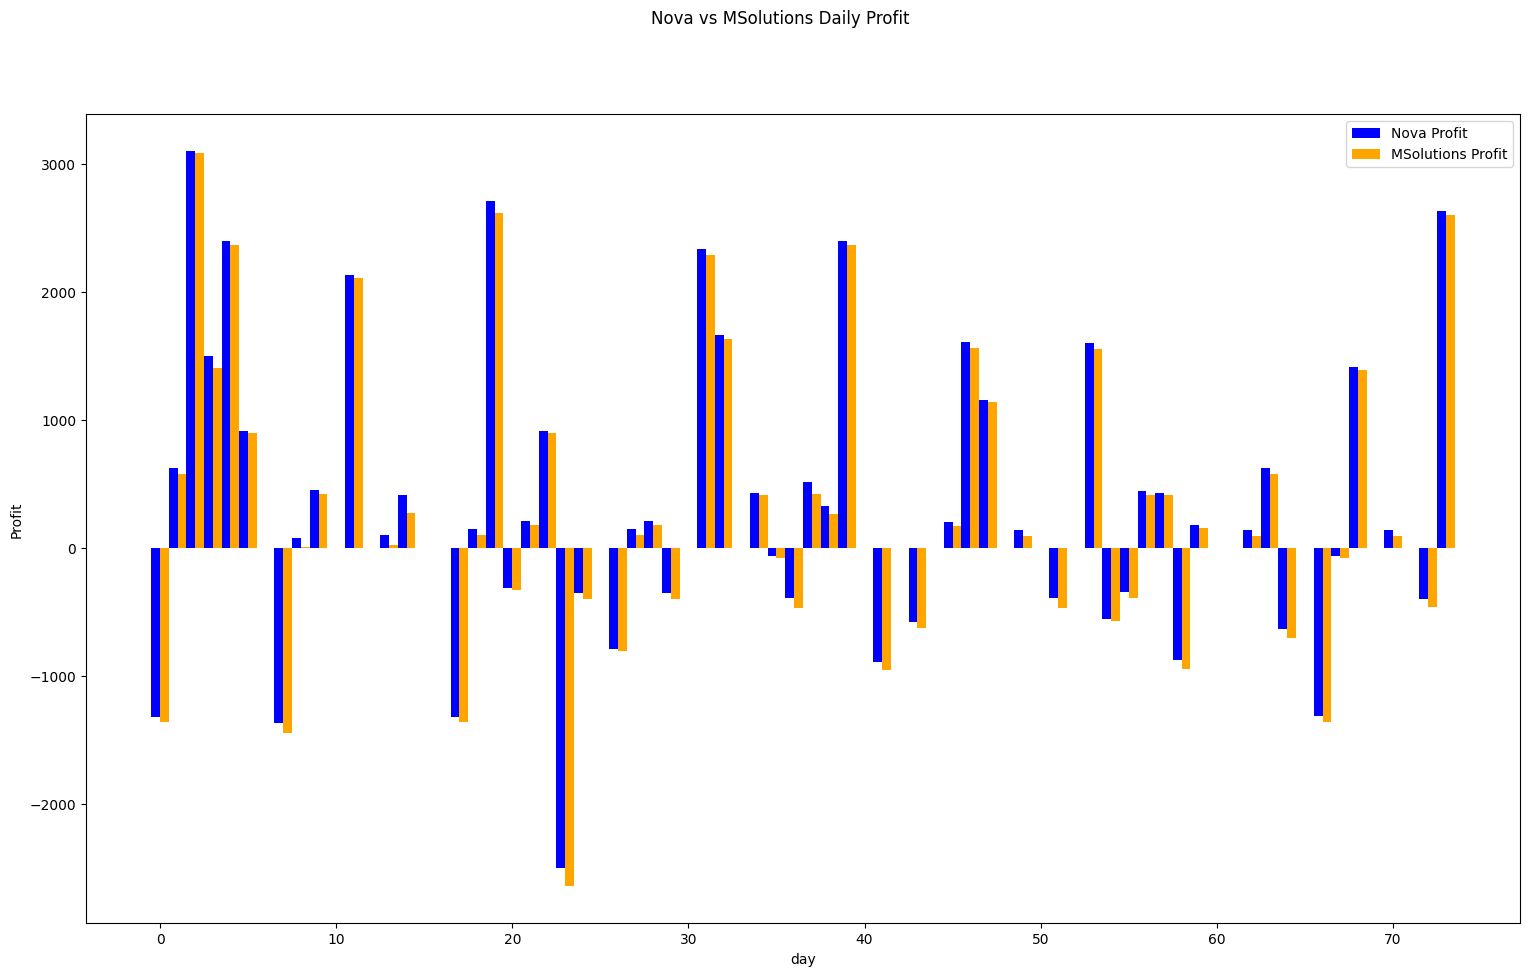

In [675]:
fig, ax = plt.subplots()
width = 0.5

# convert the index to an integer
profit_df_daily_last_3_months['day_number'] = profit_df_daily_last_3_months.index.dayofyear 
# add a column for the 
profit_df_daily_last_3_months['day_name'] = profit_df_daily_last_3_months.index.strftime('%U')
# convert the dai_name to an integer
profit_df_daily_last_3_months['day_name'] = profit_df_daily_last_3_months['day_name'].astype(int)
# reset the index
profit_df_daily_last_3_months_reset = profit_df_daily_last_3_months.reset_index()

# Nova Profit
ax.bar(profit_df_daily_last_3_months_reset.index - width/2, profit_df_daily_last_3_months_reset['nova_profit'], label='Nova Profit', color='blue', width=width)

# MSolutions Profit
ax.bar(profit_df_daily_last_3_months_reset.index + width/2, profit_df_daily_last_3_months_reset['msolutions_profit'], label='MSolutions Profit', color='orange', width=width)

ax.set_xlabel('day')
ax.set_ylabel('Profit')
fig.suptitle('Nova vs MSolutions Daily Profit')
fig.set_size_inches(18.5, 10.5)
ax.legend()
plt.show()

In [676]:
# find the number of times that profit_df_daily is below zero
profit_df_daily['nova_negative'] = np.where(profit_df_daily['nova_profit'] < 0, 1, 0)
# find the sum of nova_negative and msolutions_negative
nova_negative_sum = profit_df_daily['nova_negative'].sum()
total_days = len(profit_df_daily.index)
total_profit = profit_df['nova_profit'].sum()
min_nova_daily = profit_df_daily['nova_profit'].min()
print(nova_negative_sum, total_days, nova_negative_sum/total_days, '${:,.2f}'.format(total_profit), min_nova_daily)
# 75 343 0.21865889212827988 $388,370.88 -3304.2933163785315

131 353 0.37110481586402266 $115,757.52 -2838.0000000003347


## Summation and Plotting

In [677]:
# use the entry time and resample to each day and find the sum of the profit
profit_df['entry_time'] = pd.to_datetime(profit_df['entry_time'])
profit_df_new_index = profit_df.set_index('entry_time')
# find the sum of the nova and msolutions profit for each week
profit_df_weekly = profit_df_new_index.resample('W').agg({'nova_profit': 'sum', 'msolutions_profit': 'sum'})
# fill the null values with 0
profit_df_weekly.fillna(0, inplace=True)
# find the min, max, and mean of nova_profit and msolutions_profit
nova_min = profit_df_weekly['nova_profit'].min()
msolutions_min = profit_df_weekly['msolutions_profit'].min()
nova_max = profit_df_weekly['nova_profit'].max()
msolutions_max = profit_df_weekly['msolutions_profit'].max()
nova_mean = profit_df_weekly['nova_profit'].mean()
msolutions_mean = profit_df_weekly['msolutions_profit'].mean()
print('nova_min: ', nova_min, 'msolutions_min: ', msolutions_min, 'nova_max: ', nova_max, 'msolutions_max: ', msolutions_max, 'nova_mean: ', nova_mean, 'msolutions_mean: ', msolutions_mean)
# nova_min:  -1519.0033364526792 msolutions_min:  -2521.0033364526794 nova_max:  22138.90381578041 msolutions_max:  20752.90381578041 nova_mean:  5628.56341916719 msolutions_mean:  5032.650375688929

nova_min:  -6573.248482601593 msolutions_min:  -7486.7484826008495 nova_max:  7819.516767982181 msolutions_max:  7603.516767982317 nova_mean:  1630.387577702303 msolutions_mean:  1325.1903946039768


In [678]:
# export profit_df to a csv file
# profit_df.to_csv('C:/Users/WilliamFetzner/Documents/Trading/profit_df_new.csv')

In [679]:
# filter profit_df_weekly to just september 
# profit_df_weekly.loc['2023-09']

In [680]:
# use the entry time and resample to each day and find the sum of the profit
profit_df['entry_time'] = pd.to_datetime(profit_df['entry_time'])
profit_df_new_index = profit_df.set_index('entry_time')
# find the sum of the nova and msolutions profit for each month
profit_df_monthly = profit_df_new_index.resample('ME').agg({'nova_profit': 'sum', 'msolutions_profit': 'sum'})
# fill the null values with 0
profit_df_monthly.fillna(0, inplace=True)
# find the min, max, and mean of nova_profit
nova_min = profit_df_monthly['nova_profit'].min()
nova_max = profit_df_monthly['nova_profit'].max()
nova_mean = profit_df_monthly['nova_profit'].mean()
print('nova_min: ', nova_min, 'nova_max: ', nova_max, 'nova_mean: ', nova_mean)
# find where the nova_profit is equal to the nova_min
profit_df_monthly.loc[profit_df_monthly['nova_profit'] == nova_min]
# nova_min:  2403.0753103836196 nova_max:  47489.46822862073 nova_mean:  22845.345642502114

nova_min:  -3507.1797655590526 nova_max:  24962.975360037366 nova_mean:  6809.2657656978545


,nova_profit,msolutions_profit
entry_time,,
2022-11-30,-3507.179766,-5227.679766


In [681]:
profit_df_monthly

,nova_profit,msolutions_profit
entry_time,,
2022-11-30,-3507.179766,-5227.679766
2022-12-31,1686.828355,-1103.171645
2023-01-31,9054.858009,6978.858009
2023-02-28,10475.122845,9050.122845
2023-03-31,24962.975360,23056.475360
2023-04-30,12735.115525,11665.615525
2023-05-31,6981.001663,5725.501663
2023-06-30,10097.933132,9290.933132
2023-07-31,3305.822068,2050.322068


In [682]:
# find the end balance for nova profit and msolutions profit by summing the profits and adding to the starting balance
nova_end_balance = balance + profit_df['nova_profit'].sum()
# convert to dollars
nova_end_balance_dollars = '${:,.2f}'.format(nova_end_balance)
msolutions_end_balance = balance + profit_df['msolutions_profit'].sum()
msolutions_end_balance_dollars = '${:,.2f}'.format(msolutions_end_balance)
print(f'Nova End Balance: {nova_end_balance_dollars}')
print(f'MSolutions End Balance: {msolutions_end_balance_dollars}')
# 4 sma/smoothing and no pyramiding
# Nova End Balance: $588,370.88
# MSolutions End Balance: $547,252.88

Nova End Balance: $315,757.52
MSolutions End Balance: $294,088.52


In [683]:
total_take_home = ((nova_end_balance-balance)*.8 )+ ((msolutions_end_balance-balance)*.75)
print(total_take_home)
# with initial TP
# 571136.35
# 163,172.40 - 4 sma/smoothing and no pyramiding
# 129,749.84 - 3 sma/smoothing and no pyramiding
# 590,883.60 - 4 sma/smoothing and 4 pyramiding

163172.40292615257


In [684]:
# calculate the win rate for nova
nova_win_rate = profit_df.loc[profit_df['nova_profit'] > 0].shape[0] / profit_df.shape[0]
msolutions_win_rate = profit_df.loc[profit_df['msolutions_profit'] > 0].shape[0] / profit_df.shape[0]
# find the number of times that initial TP was hit and then the 
print('Nova Win Rate: ', nova_win_rate, 'MSolutions Win Rate: ', msolutions_win_rate)
# Nova Win Rate:  0.4040728831725616 MSolutions Win Rate:  0.4040728831725616 - 4 sma/smoothing and no pyramiding
# Nova Win Rate:  0.37916310845431256 MSolutions Win Rate:  0.37916310845431256 - 3 sma/smoothing and no pyramiding
# Nova Win Rate:  0.3762057877813505 MSolutions Win Rate:  0.3740621650589496 - 4 sma/smoothing and 4 pyramiding

Nova Win Rate:  0.4040728831725616 MSolutions Win Rate:  0.4040728831725616


In [685]:
# find the min for nova_profit and msolutions_profit
nova_min = profit_df['nova_profit'].min()
msolutions_min = profit_df['msolutions_profit'].min()
print(f'Nova Min: ${nova_min}')
print(f'MSolutions Min: ${msolutions_min}')
# find the max for nova_profit and msolutions_profit
nova_max = profit_df['nova_profit'].max()
msolutions_max = profit_df['msolutions_profit'].max()
print(f'Nova Max: ${nova_max}')
print(f'MSolutions Max: ${msolutions_max}')
# 4 sma/smoothing and no pyramiding
# Nova Min: $-796.9274479959886
# MSolutions Min: $-813.4274479959241
# Nova Max: $6014.999999999763
# MSolutions Max: $5998.499999999827
# 3 sma/smoothing and no pyramiding
# Nova Min: $-797.0341515714808
# MSolutions Min: $-813.5341515714165
# Nova Max: $4331.999999999862
# MSolutions Max: $4301.999999999838
# 4 sma/smoothing and 4 pyramiding
# Nova Min: $-1511.9999999999823
# MSolutions Min: $-1660.499999999403
# Nova Max: $67700.99999999582
# MSolutions Max: $67139.999999998

Nova Min: $-796.9274479959886
MSolutions Min: $-813.4274479959241
Nova Max: $6014.999999999763
MSolutions Max: $5998.499999999827


In [686]:
# average RR ratio
# find the average RR ratio for nova_profit and msolutions_profit
# find the average profit for trades that were positive for nova_profit
nova_avg_profit = profit_df.loc[profit_df['nova_profit'] > 0]['nova_profit'].mean()
# find the average profit for trades that were negative for nova_profit
nova_avg_loss = profit_df.loc[profit_df['nova_profit'] < 0]['nova_profit'].mean()
nova_avg_profit/abs(nova_avg_loss)
# 2.4026609764044577
# 4.584709176903244 - 4 sma/smoothing and 4 pyramiding

2.2973934737293487

In [687]:
# create a new column for cum_sum of nova_profit and msolutions_profit
profit_df['nova_cum_sum'] = profit_df['nova_profit'].cumsum()
profit_df['msolutions_cum_sum'] = profit_df['msolutions_profit'].cumsum()

In [688]:
# find the min of nova_cum_sum
nova_min_cum_sum_min = profit_df['nova_cum_sum'].min()
nova_min_cum_sum_min
# -287.99999999990365
# -14132.199224597824 - 3 sma/smoothing and no pyramiding
# -11296.252317561777 - 4 sma/smoothing and 4 pyramiding

-7741.252317562354

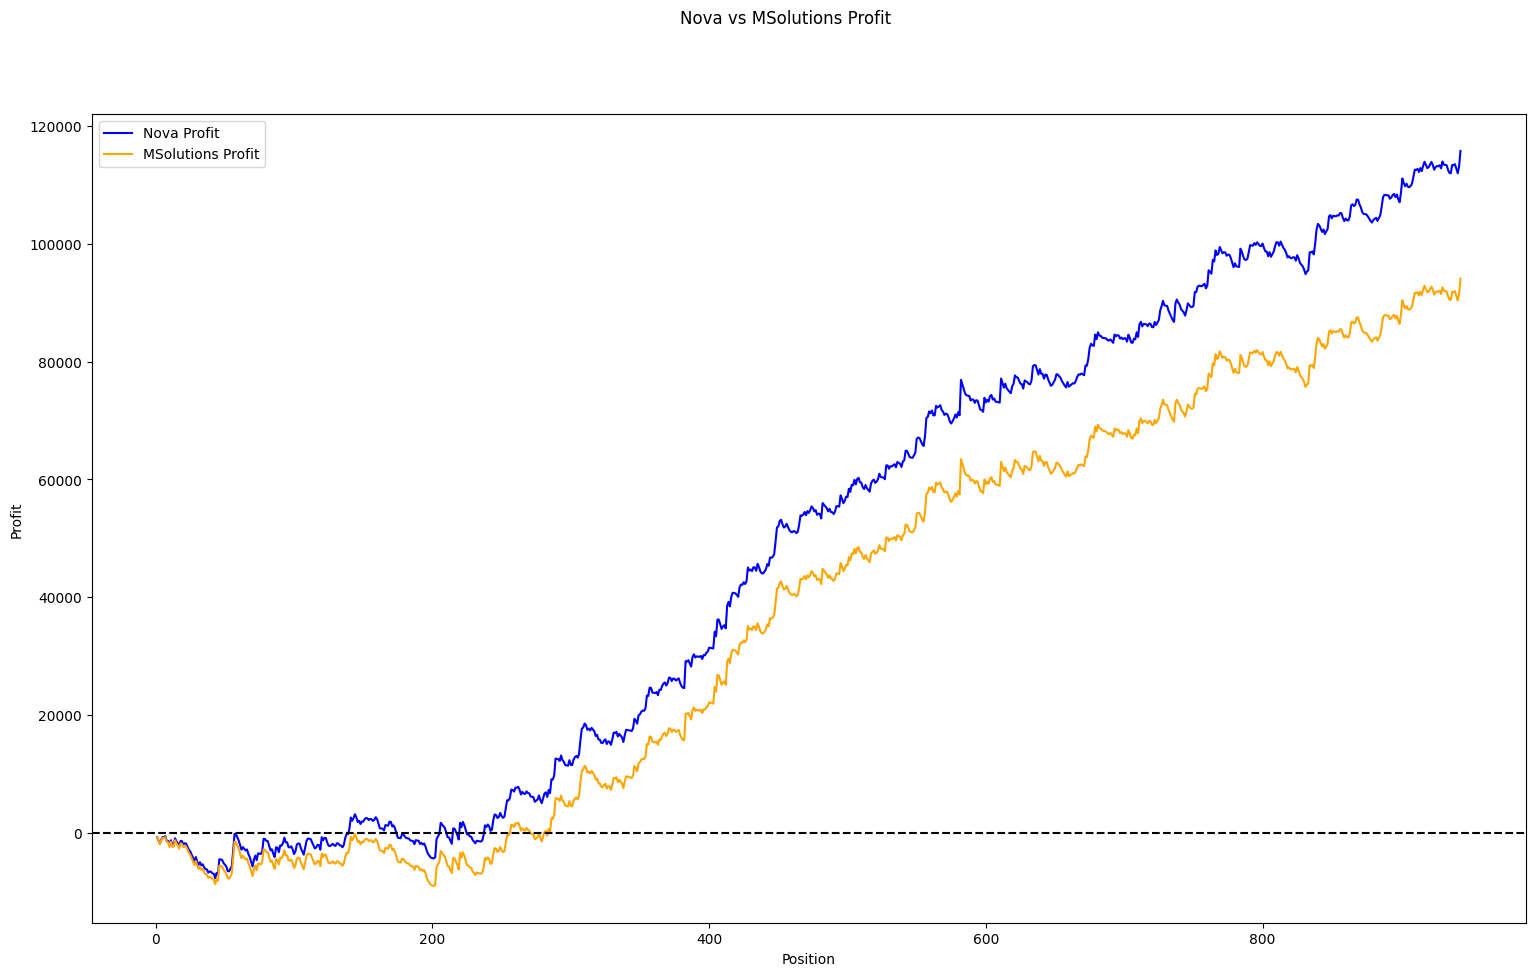

In [689]:
# graph nova_profit_dollars and msolutions_profit_dollars over cum_position_count
fig, ax = plt.subplots()
ax.plot(profit_df['nova_cum_sum'], label='Nova Profit', color='blue')
ax.plot(profit_df['msolutions_cum_sum'], label='MSolutions Profit', color='orange')
# add in a line for 0 
ax.axhline(y=0, color='black', linestyle='--')
ax.set_xlabel('Position')
ax.set_ylabel('Profit')
fig.suptitle('Nova vs MSolutions Profit')
# increase the size of the chart
fig.set_size_inches(18.5, 10.5)
# Add legend
ax.legend()
# Show the plot
plt.show()


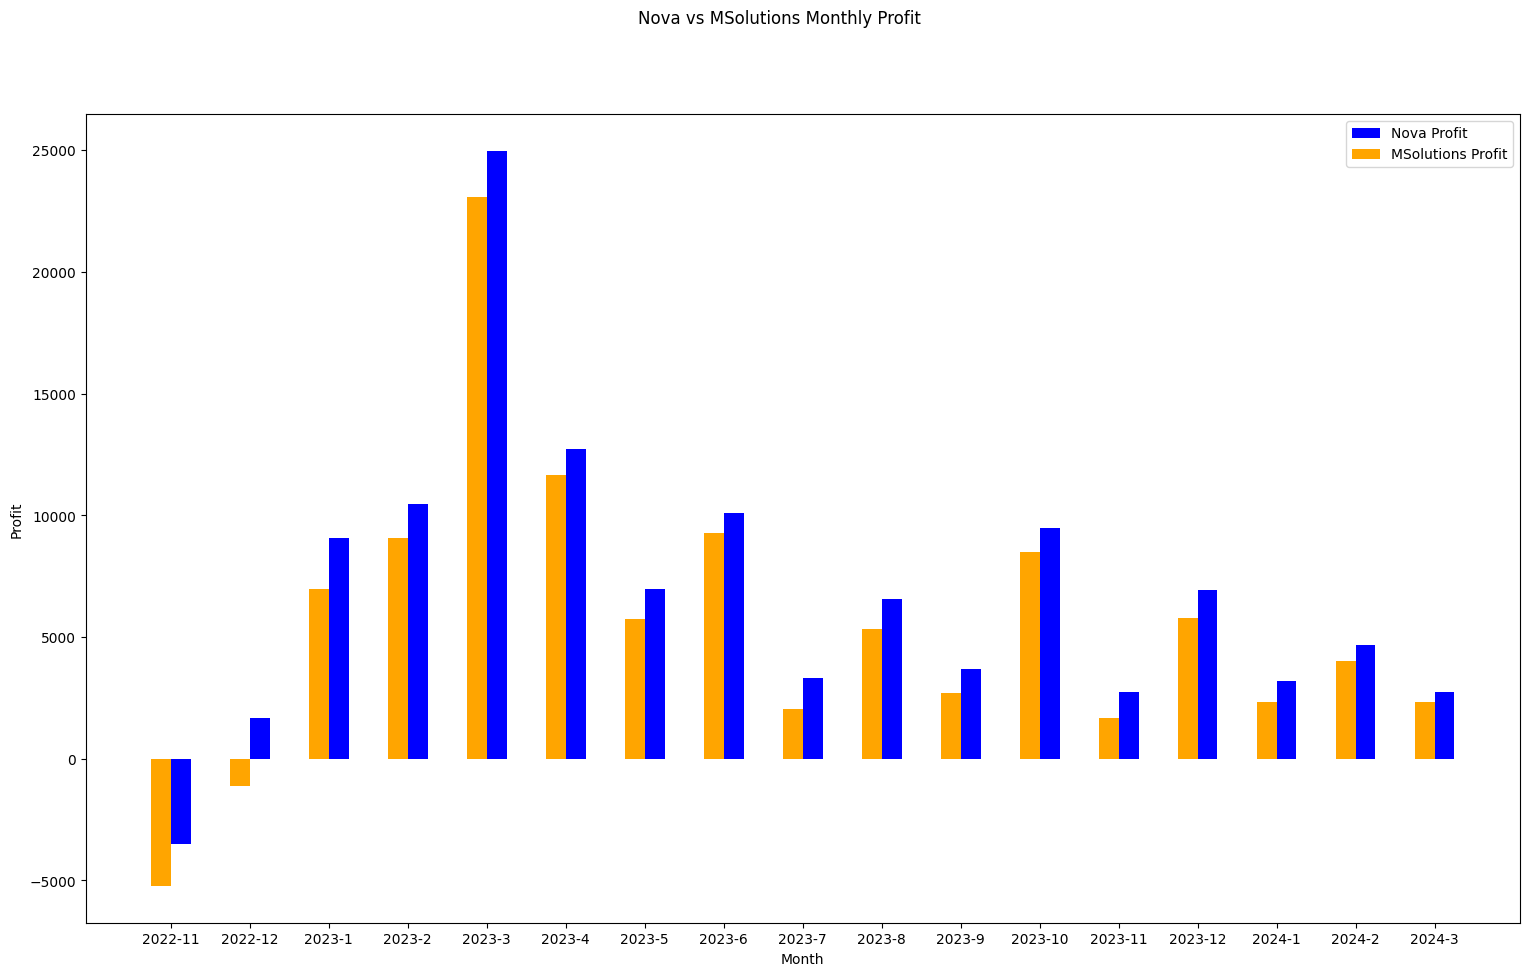

In [690]:
fig, ax = plt.subplots()
width = 0.5

# convert the index to an integer
profit_df_monthly['month'] = profit_df_monthly.index.month
# add a column for the year
profit_df_monthly['year'] = profit_df_monthly.index.year
# concat the year and month like '2023-01'
profit_df_monthly['year_month'] = profit_df_monthly['year'].astype(str) + '-' + profit_df_monthly['month'].astype(str)
# add a column for the month name
profit_df_monthly['month_name'] = profit_df_monthly.index.strftime('%B')
# profit_df_monthly
# reindex the dataframe
profit_df_monthly_reset = profit_df_monthly.reset_index()

# Nova Profit
ax.bar(profit_df_monthly_reset.index + width/4, profit_df_monthly_reset['nova_profit'], label='Nova Profit', color='blue', width=width/2)

# MSolutions Profit
ax.bar(profit_df_monthly_reset.index - width/4, profit_df_monthly_reset['msolutions_profit'], label='MSolutions Profit', color='orange', width=width/2)

# set the x axis labels to be from the column 'year_month'
ax.set_xticks(profit_df_monthly_reset.index)
ax.set_xticklabels(profit_df_monthly_reset['year_month'])

ax.set_xlabel('Month')
ax.set_ylabel('Profit')
fig.suptitle('Nova vs MSolutions Monthly Profit')
fig.set_size_inches(18.5, 10.5)
ax.legend()
plt.show()


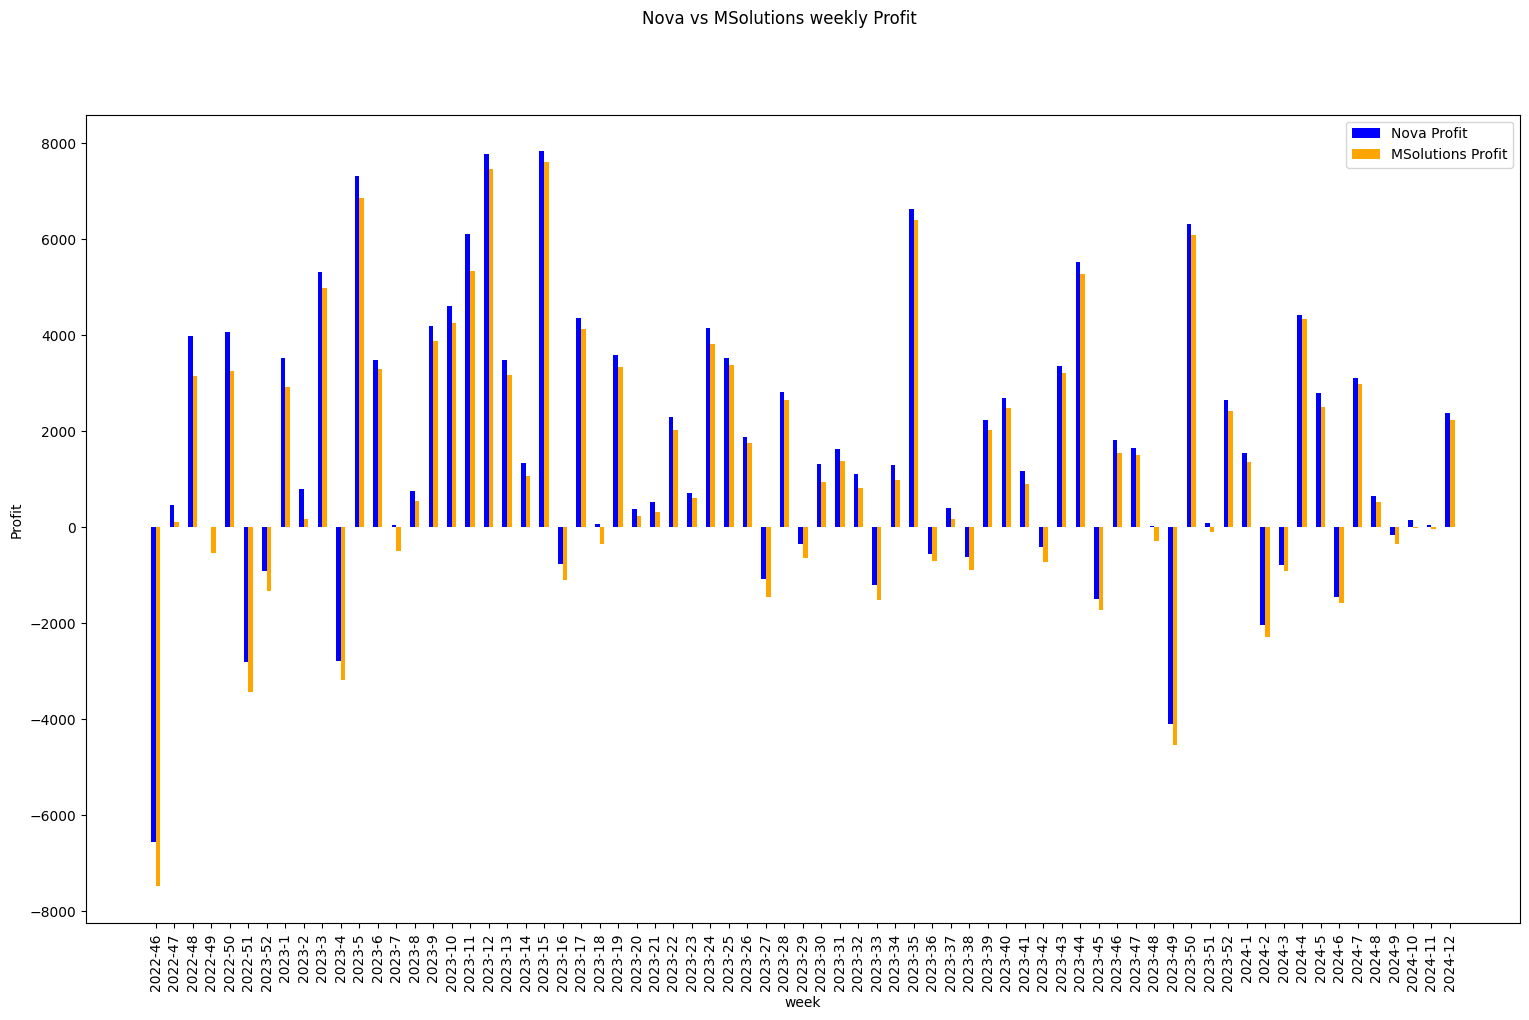

In [691]:
fig, ax = plt.subplots()
width = 0.5

# convert the index to an integer
profit_df_weekly['week'] = profit_df_weekly.index.isocalendar().week
# add a column for the week name
profit_df_weekly['week_name'] = profit_df_weekly.index.strftime('%U')
# convert the week_name to an integer
profit_df_weekly['week_name'] = profit_df_weekly['week_name'].astype(int)
# get the year
profit_df_weekly['year'] = profit_df_weekly.index.year
# concat the year and week like '2023-01'
profit_df_weekly['year_week'] = profit_df_weekly['year'].astype(str) + '-' + profit_df_weekly['week'].astype(str)
# reset the index
profit_df_weekly_reset = profit_df_weekly.reset_index()

# Nova Profit
ax.bar(profit_df_weekly_reset.index - width/4, profit_df_weekly_reset['nova_profit'], label='Nova Profit', color='blue', width=width/2)

# MSolutions Profit
ax.bar(profit_df_weekly_reset.index + width/4, profit_df_weekly_reset['msolutions_profit'], label='MSolutions Profit', color='orange', width=width/2)


# set the x axis labels to be from the column 'year_month'
ax.set_xticks(profit_df_weekly_reset.index)
ax.set_xticklabels(profit_df_weekly_reset['year_week'])
# rotate the x axis labels vertically
plt.xticks(rotation=90)

ax.set_xlabel('week')
ax.set_ylabel('Profit')
fig.suptitle('Nova vs MSolutions weekly Profit')
fig.set_size_inches(18.5, 10.5)
ax.legend()
plt.show()


In [692]:
# what is the median of nova_profit
nova_median = profit_df_weekly['nova_profit'].median()
print('Nova Median: ', nova_median)
# what is the average
nova_mean = profit_df_weekly['nova_profit'].mean()
print('Nova Mean: ', nova_mean)

# 3 sma/smoothing and no pyramiding
# Nova Median:  1629.1363948608353
# Nova Mean:  1364.3034679851164
# 4 sma/smoothing and 4 pyramiding
# Nova Median:  1276.5555721774658
# Nova Mean:  5679.035465025976


Nova Median:  1318.4665374496974
Nova Mean:  1630.387577702303


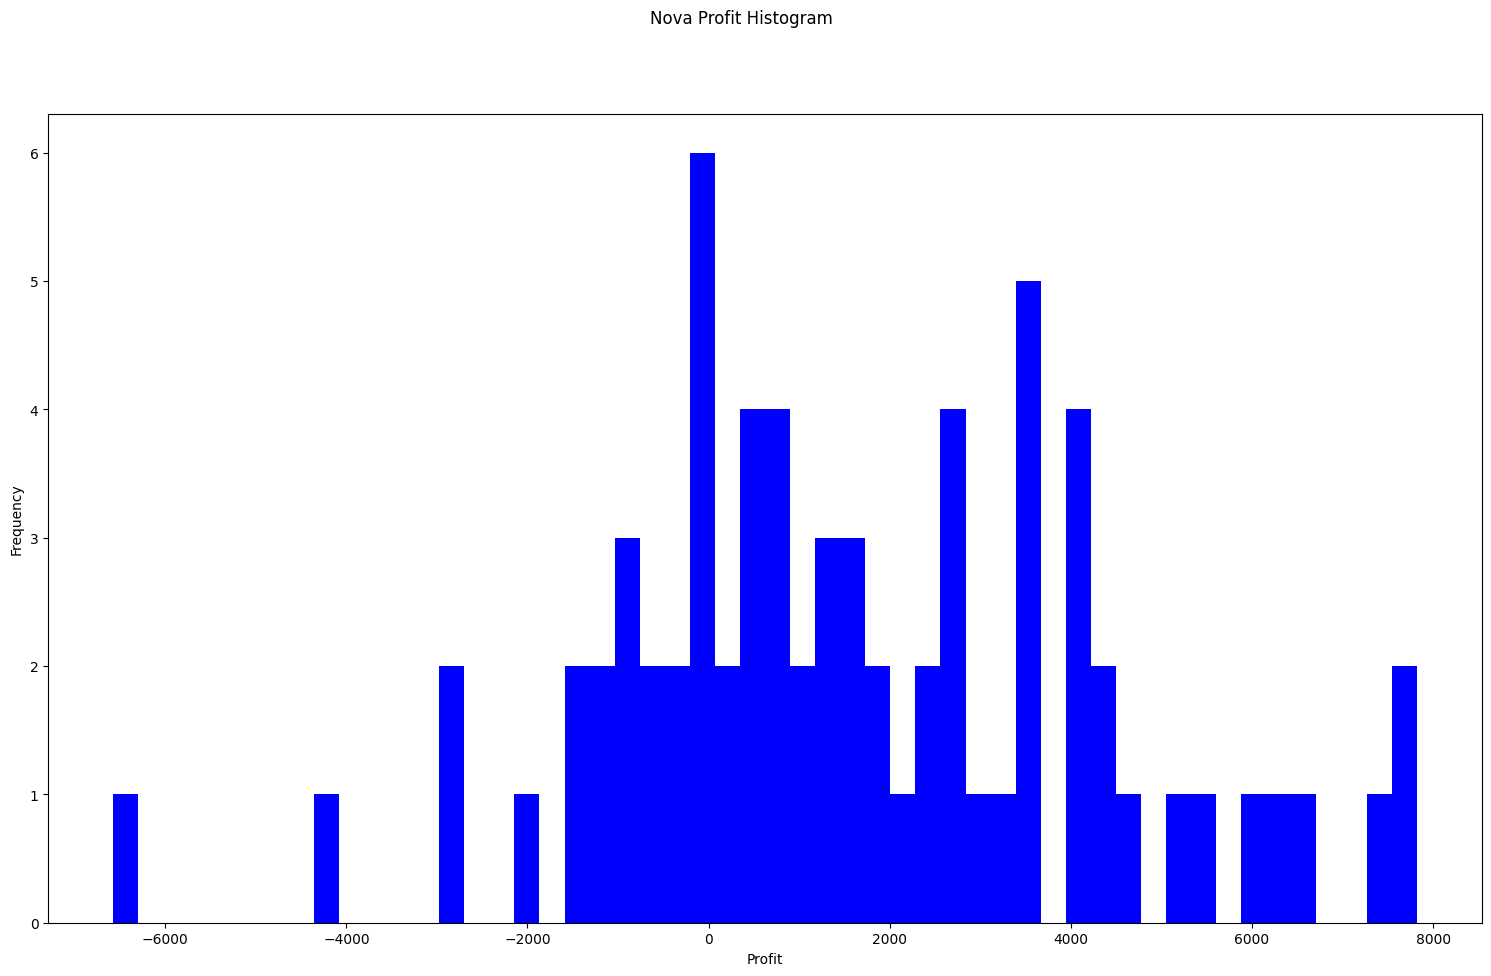

In [693]:
# create a histogram of the nova_profit for each week
fig, ax = plt.subplots()
ax.hist(profit_df_weekly['nova_profit'], bins=52, color='blue')
ax.set_xlabel('Profit')
ax.set_ylabel('Frequency')
fig.suptitle('Nova Profit Histogram')
fig.set_size_inches(18.5, 10.5)
plt.show()


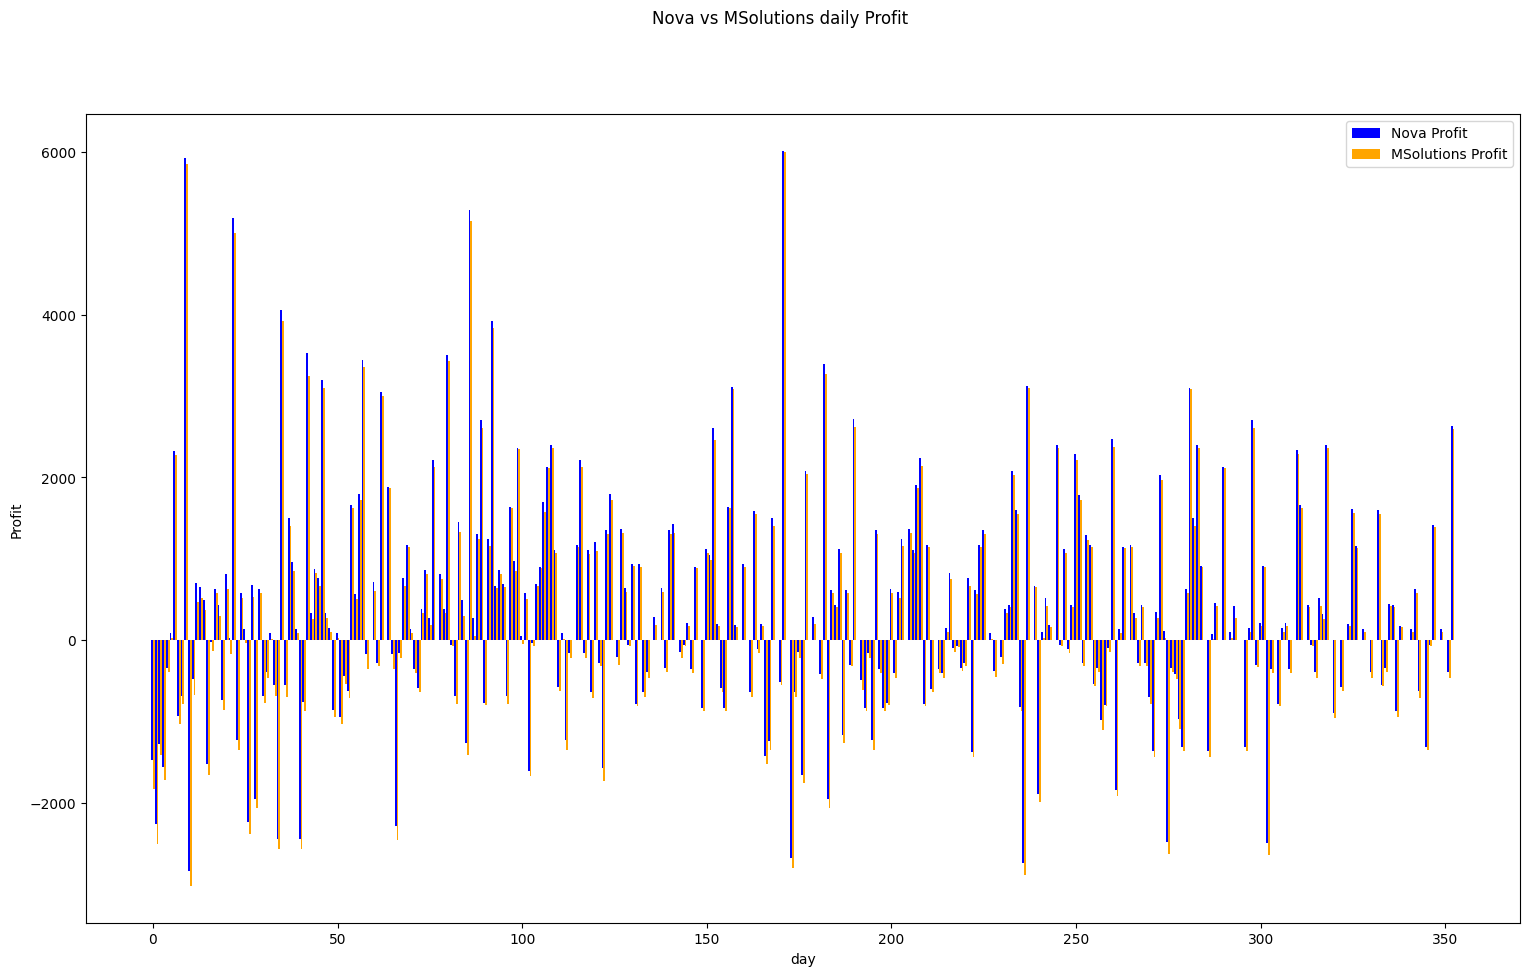

In [694]:
fig, ax = plt.subplots()
width = 0.5

# convert the index to an integer
profit_df_daily['day_number'] = profit_df_daily.index.dayofyear 
# add a column for the 
profit_df_daily['day_name'] = profit_df_daily.index.strftime('%U')
# convert the dai_name to an integer
profit_df_daily['day_name'] = profit_df_daily['day_name'].astype(int)
# reset the index
profit_df_daily_reset = profit_df_daily.reset_index()

# Nova Profit
ax.bar(profit_df_daily_reset.index - width/2, profit_df_daily_reset['nova_profit'], label='Nova Profit', color='blue', width=width)

# MSolutions Profit
ax.bar(profit_df_daily_reset.index + width/2, profit_df_daily_reset['msolutions_profit'], label='MSolutions Profit', color='orange', width=width)

ax.set_xlabel('day')
ax.set_ylabel('Profit')
fig.suptitle('Nova vs MSolutions daily Profit')
fig.set_size_inches(18.5, 10.5)
ax.legend()
plt.show()


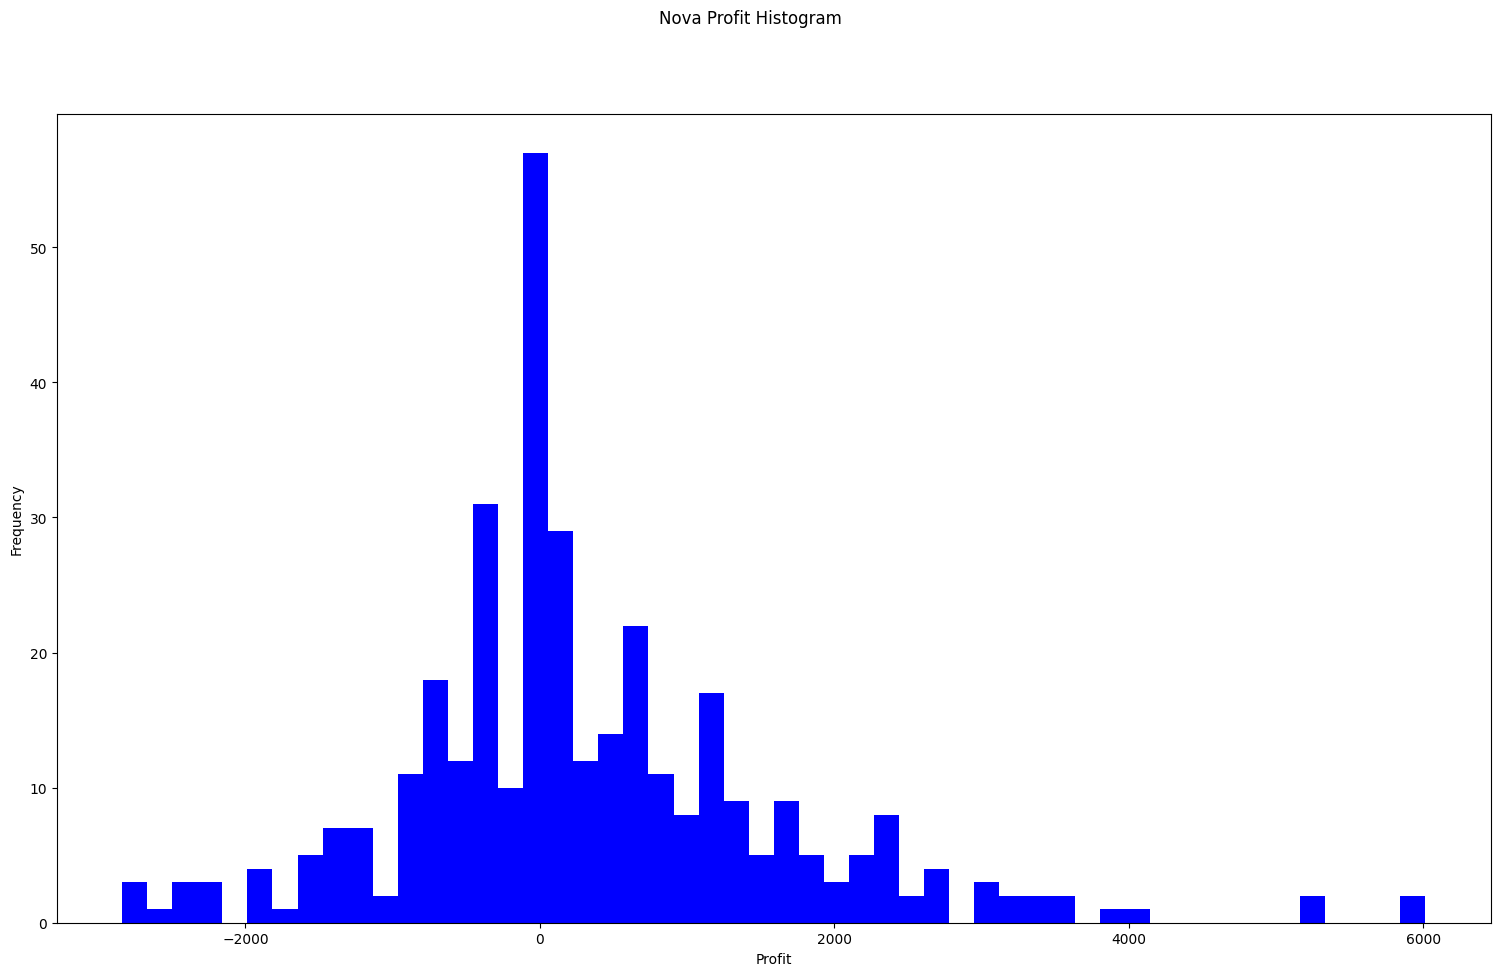

In [695]:
# create a histogram of the nova_profit for each week
fig, ax = plt.subplots()
ax.hist(profit_df_daily['nova_profit'], bins=52, color='blue')
ax.set_xlabel('Profit')
ax.set_ylabel('Frequency')
fig.suptitle('Nova Profit Histogram')
fig.set_size_inches(18.5, 10.5)
plt.show()


In [696]:
# show the bins and counts from histogram in a table
nova_profit_hist = np.histogram(profit_df_daily['nova_profit'], bins=52)
# put this into a pandas dataframe
nova_profit_hist_df = pd.DataFrame({'bin': nova_profit_hist[1][:-1], 'count': nova_profit_hist[0]})
nova_profit_hist_df


,bin,count
0,-2838.00,3
1,-2667.75,1
2,-2497.50,3
3,-2327.25,3
4,-2157.00,0
5,-1986.75,4
6,-1816.50,1
7,-1646.25,5
8,-1476.00,7
9,-1305.75,7


In [697]:
# how many entry times were within 5 minutes of 8:30 am
# separate the hours and minutes from the entry_time column
profit_df['entry_time'] = pd.to_datetime(profit_df['entry_time'])
profit_df['entry_hour'] = profit_df['entry_time'].dt.hour
profit_df['entry_minute'] = profit_df['entry_time'].dt.minute

# if the entry_hour is 8 and the entry_minute is between 25 and 35 then add a column called 'entry_8_30' and set it to 1
profit_df['entry_8_30'] = np.where((profit_df['entry_hour'] == 8) & (profit_df['entry_minute'] >= 25) & (profit_df['entry_minute'] <= 35), 1, 0)
# find the sum of the entry_8_30 column
entry_8_30_count = profit_df['entry_8_30'].sum()
print('Entry 8:30 Count: ', entry_8_30_count)

Entry 8:30 Count:  6


## Hour distribution

In [698]:
profit_df

,entry_price,entry_time,exit_time,exit_price,direction,brick_color,nova_profit_initial,msolutions_profit_initial,nova_spread_exit_price,msolutions_spread_exit_price,...,msolutions_profit_pyramid_sum,nova_profit,msolutions_profit,entry_day_of_week,exit_day_of_week,nova_cum_sum,msolutions_cum_sum,entry_hour,entry_minute,entry_8_30
cum_position_count,,,,,,,,,,,,,,,,,,,,,
0,1.03356,2022-11-15 08:13:02.507,2022-11-15 10:37:09.822,1.04004,None,green,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,Tuesday,Tuesday,NaN,NaN,8,13,0
1,1.03923,2022-11-15 11:23:05.995,2022-11-15 12:31:05.758,1.04166,sell,red,-762.0,-786.0,1.04174,1.04174,...,0.0,-771.000000,-801.000000,Tuesday,Tuesday,-771.000000,-801.000000,11,23,0
2,1.04247,2022-11-15 12:37:55.531,2022-11-15 14:03:31.670,1.04085,buy,green,-537.0,-547.5,1.04075,1.04074,...,0.0,-546.000000,-562.500000,Tuesday,Tuesday,-1317.000000,-1363.500000,12,37,0
3,1.04004,2022-11-15 14:15:25.349,2022-11-15 15:30:05.830,1.04166,sell,red,-519.0,-543.0,1.04174,1.04174,...,0.0,-528.000000,-558.000000,Tuesday,Tuesday,-1845.000000,-1921.500000,14,15,0
4,1.04247,2022-11-15 15:30:15.262,2022-11-15 15:41:58.165,1.04490,buy,green,678.0,667.5,1.04480,1.04479,...,0.0,669.000000,652.500000,Tuesday,Tuesday,-1176.000000,-1269.000000,15,30,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,1.08702,2024-03-18 19:25:57.817,2024-03-19 17:15:53.642,1.08621,sell,red,210.0,186.0,1.08629,1.08629,...,0.0,201.000000,171.000000,Monday,Tuesday,113523.951176,91947.951176,19,25,0
940,1.08702,2024-03-20 06:13:30.844,2024-03-20 12:07:58.310,1.08459,buy,green,-780.0,-790.5,1.08449,1.08448,...,0.0,-789.000000,-805.500000,Wednesday,Wednesday,112734.951176,91142.451176,6,13,0
941,1.08378,2024-03-20 12:54:02.219,2024-03-20 20:10:54.681,1.08621,sell,red,-762.0,-786.0,1.08629,1.08629,...,0.0,-763.433159,-793.433159,Wednesday,Wednesday,111971.518017,90349.018017,12,54,0


In [699]:
# find the win rate grouped by entry_hour and the number of trades taken for each hour
win_rate_by_hour = profit_df.groupby('entry_hour').agg({'nova_profit': lambda x: (x > 0).sum() / x.count(), 'entry_time': 'count'})
win_rate_by_hour

,nova_profit,entry_time
entry_hour,,
0,0.500000,8
1,0.333333,12
2,0.388889,18
3,0.391304,23
4,0.500000,16
5,0.300000,10
6,0.000000,4
7,0.400000,10
8,0.500000,23


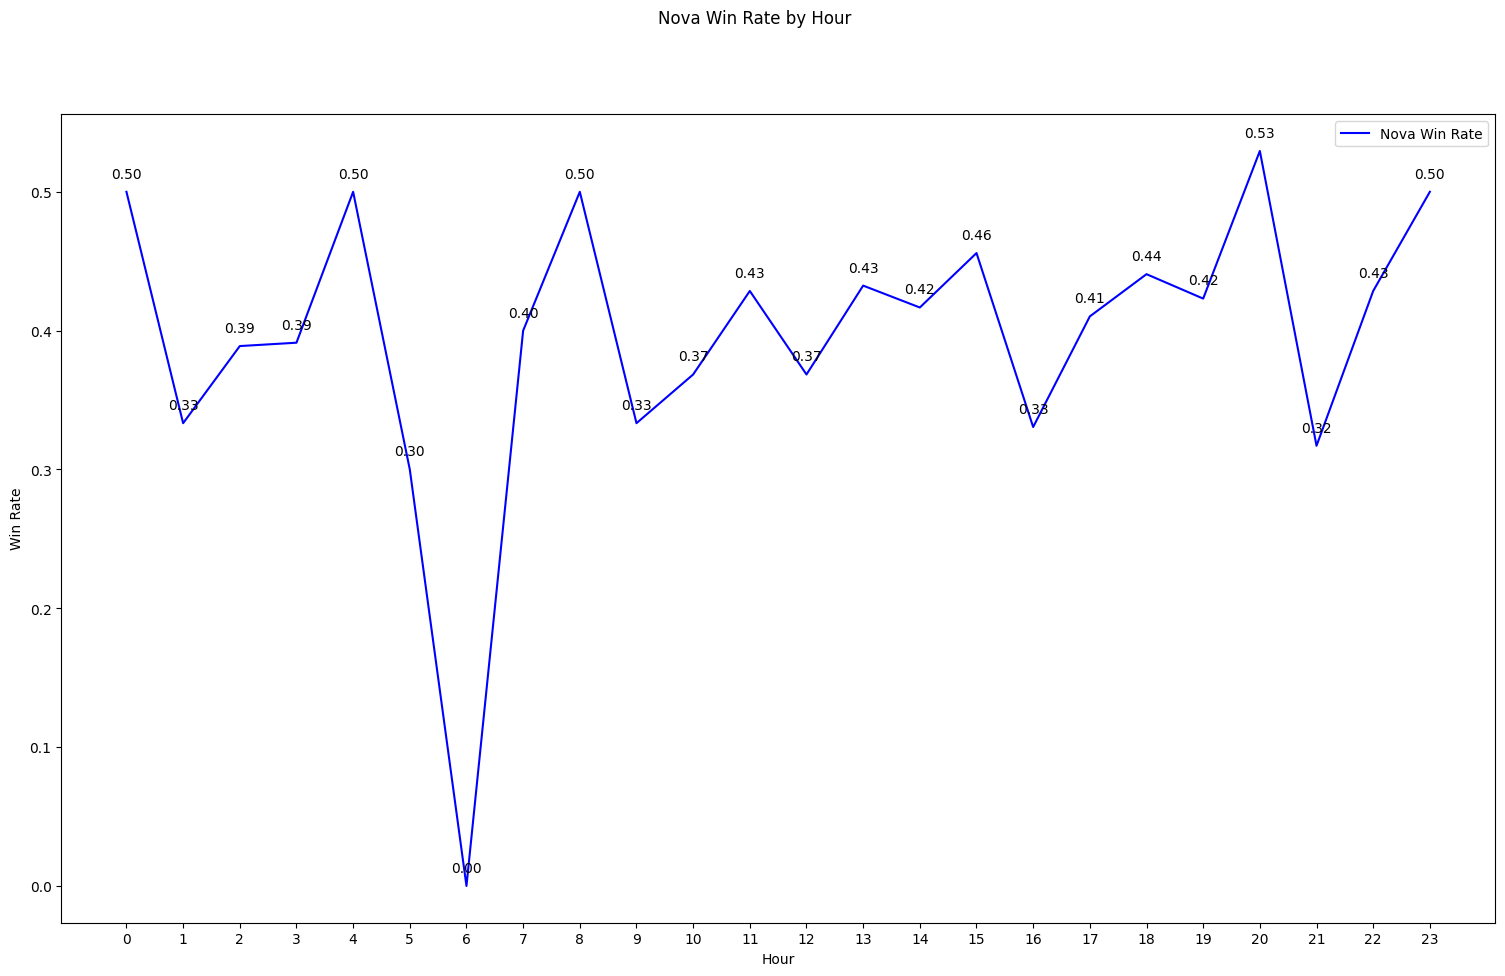

In [700]:
# create a line graph of the win rate by hour
fig, ax = plt.subplots()
ax.plot(win_rate_by_hour.index, win_rate_by_hour['nova_profit'], label='Nova Win Rate', color='blue')
# show the values for x and y next to the points
for i, txt in enumerate(win_rate_by_hour['nova_profit']):
    ax.annotate(f'{txt:.2f}', (win_rate_by_hour.index[i], win_rate_by_hour['nova_profit'][i]), textcoords="offset points", xytext=(0,10), ha='center')
# show all of the ticks on the x axis
ax.set_xticks(win_rate_by_hour.index)
ax.set_xlabel('Hour')
ax.set_ylabel('Win Rate')
fig.suptitle('Nova Win Rate by Hour')
fig.set_size_inches(18.5, 10.5)
ax.legend()
plt.show()


In [701]:
# filter out any rows that have entry_hour as 
low_win_perc_hrs = [0,23] #20, 21,
low_win_perc_removed = profit_df[~profit_df.entry_hour.isin(low_win_perc_hrs)]
# find the sum of nova profit for low_win_perc_removed
print(low_win_perc_removed['nova_profit'].sum(), profit_df['nova_profit'].sum())
# 450,269.5324621328 436,764.53246210545 (0,7,22,23)
# 447,864.53246212745 436,764.53246210545 - nighttime hours (0,22,23)


114618.94637223316 115757.51801686353


In [702]:
# export the profit_df to a csv
# profit_df.to_csv('profit_df.csv')

## Investigation of losing trades

In [703]:
# add a new column to profit_df that is the number of rows in renko_full_data for each position
profit_df['num_rows'] = renko_full_data.groupby('cum_position_count').size()
# filter profit_df to just the losing positions
losing_positions = profit_df[profit_df['nova_profit'] < 0]
min_loss = losing_positions.msolutions_profit.min()
losing_positions.loc[losing_positions['msolutions_profit'] == min_loss]

,entry_price,entry_time,exit_time,exit_price,direction,brick_color,nova_profit_initial,msolutions_profit_initial,nova_spread_exit_price,msolutions_spread_exit_price,...,nova_profit,msolutions_profit,entry_day_of_week,exit_day_of_week,nova_cum_sum,msolutions_cum_sum,entry_hour,entry_minute,entry_8_30,num_rows
cum_position_count,,,,,,,,,,,,,,,,,,,,,
70,1.03923,2022-11-30 16:17:23.879,2022-11-30 17:06:06.152,1.0368,buy,green,-780.0,-790.5,1.0367,1.03669,...,-796.927448,-813.427448,Wednesday,Wednesday,-5733.179766,-7360.679766,16,17,0,3


In [704]:
# create a list of all the losing position cum_position_count
losing_positions_list = losing_positions.index.tolist()
# find the average number of rows for each position in renko_full_data that are in the losing_positions_list
avg_rows = renko_full_data.loc[renko_full_data['cum_position_count'].isin(losing_positions_list)].shape[0] / len(losing_positions_list)
avg_rows

3.9855855855855857

In [705]:
# find the standard deviation of num_rows in losing_positions
std_rows = losing_positions.num_rows.std()
max_losing_rows = losing_positions.num_rows.max()
min_losing_rows = losing_positions.num_rows.min()
# find the number of rows that occur the most
mode_losing_rows = losing_positions.num_rows.mode()
print('std_rows: ', std_rows, 'max_losing_rows: ', max_losing_rows, 'min_losing_rows: ', min_losing_rows, 
      'avg_rows: ', avg_rows, 'mode_losing_rows: ', mode_losing_rows)



std_rows:  2.1148796744346887 max_losing_rows:  13 min_losing_rows:  1 avg_rows:  3.9855855855855857 mode_losing_rows:  0    3
Name: num_rows, dtype: int64


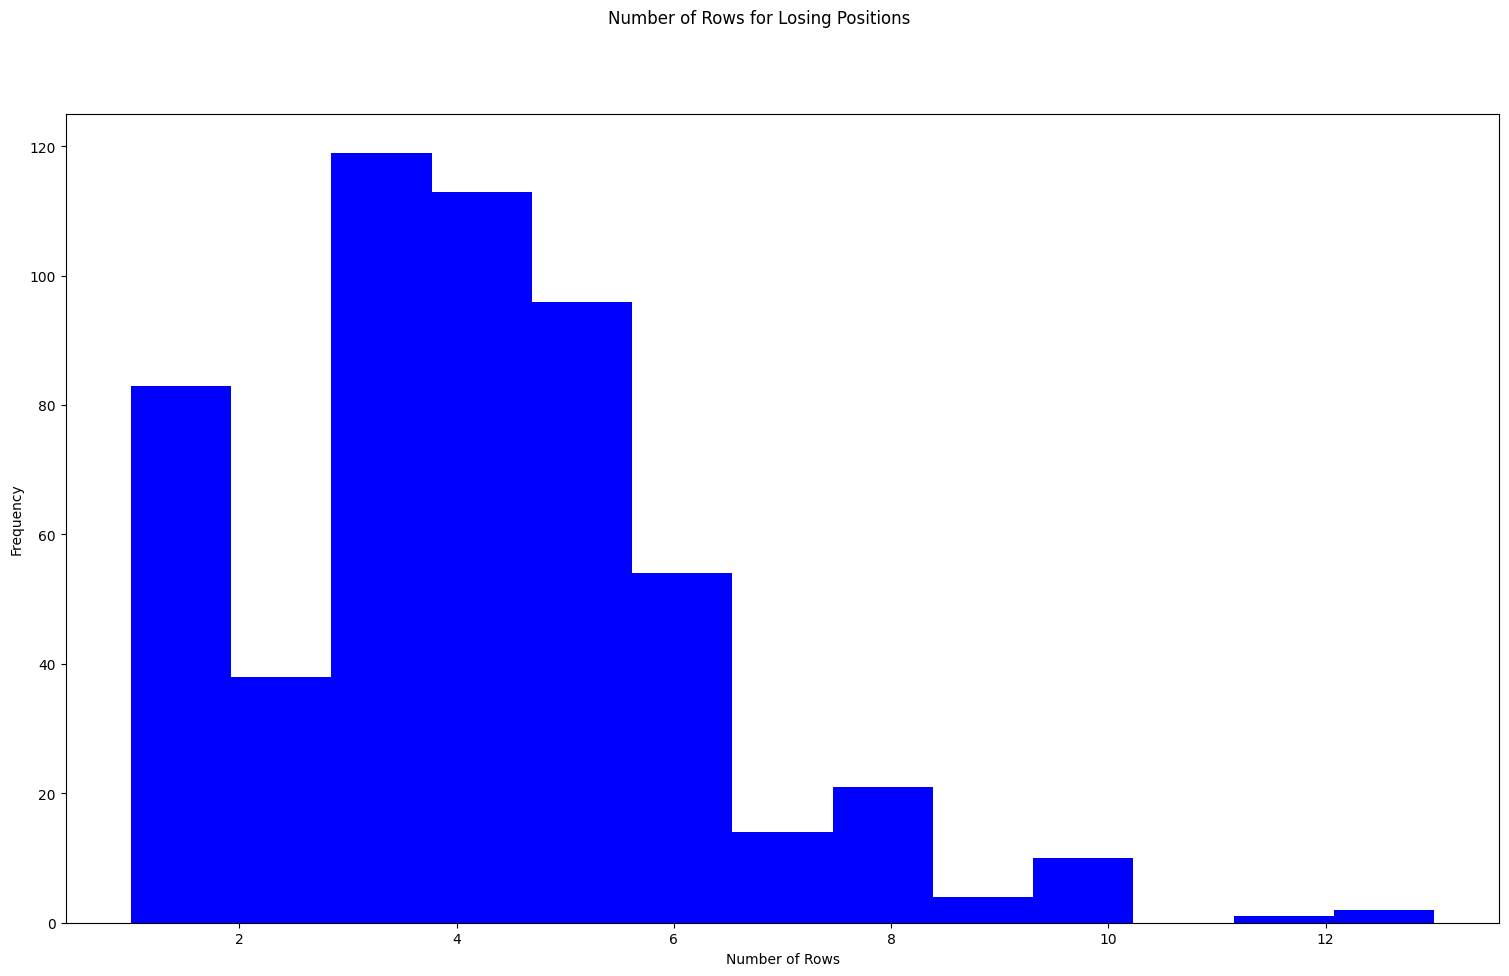

In [706]:
#create a histogram of the number of rows for the losing positions
fig, ax = plt.subplots()
ax.hist(losing_positions['num_rows'], bins=13, color='blue')
ax.set_xlabel('Number of Rows')
ax.set_ylabel('Frequency')
fig.suptitle('Number of Rows for Losing Positions')
fig.set_size_inches(18.5, 10.5)
plt.show()

In [707]:
losing_positions.loc[losing_positions['num_rows'] == 3]

,entry_price,entry_time,exit_time,exit_price,direction,brick_color,nova_profit_initial,msolutions_profit_initial,nova_spread_exit_price,msolutions_spread_exit_price,...,nova_profit,msolutions_profit,entry_day_of_week,exit_day_of_week,nova_cum_sum,msolutions_cum_sum,entry_hour,entry_minute,entry_8_30,num_rows
cum_position_count,,,,,,,,,,,,,,,,,,,,,
1,1.03923,2022-11-15 11:23:05.995,2022-11-15 12:31:05.758,1.04166,sell,red,-762.0,-786.0,1.04174,1.04174,...,-771.000000,-801.000000,Tuesday,Tuesday,-771.000000,-801.000000,11,23,0,3
8,1.04085,2022-11-15 17:34:07.233,2022-11-15 17:43:13.456,1.03842,buy,green,-780.0,-790.5,1.03832,1.03831,...,-789.000000,-805.500000,Tuesday,Tuesday,-1372.097248,-1558.097248,17,34,0,3
10,1.03842,2022-11-15 19:49:22.221,2022-11-15 20:25:58.801,1.03599,buy,green,-780.0,-790.5,1.03589,1.03588,...,-789.000000,-805.500000,Tuesday,Tuesday,-2203.097248,-2435.597248,19,49,0,3
12,1.03275,2022-11-15 20:44:09.501,2022-11-15 20:53:22.614,1.03032,buy,green,-780.0,-790.5,1.03022,1.03021,...,-789.000000,-805.500000,Tuesday,Tuesday,-2062.097248,-2341.097248,20,44,0,3
30,1.03518,2022-11-17 15:30:36.073,2022-11-17 15:42:21.320,1.03275,buy,green,-780.0,-790.5,1.03265,1.03264,...,-789.000000,-805.500000,Thursday,Thursday,-4916.188337,-5613.688337,15,30,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
906,1.07811,2024-02-08 20:02:47.395,2024-02-09 15:31:10.787,1.07811,buy,green,-51.0,-61.5,1.07801,1.07800,...,-60.000000,-76.500000,Thursday,Friday,109616.550699,88814.550699,20,2,0,3
924,1.08540,2024-02-29 17:01:02.151,2024-02-29 17:46:48.362,1.08297,buy,green,-780.0,-790.5,1.08287,1.08286,...,-789.000000,-805.500000,Thursday,Thursday,112579.018688,91358.518688,17,1,0,3
934,1.09431,2024-03-12 15:41:12.450,2024-03-12 15:59:05.393,1.09188,buy,green,-780.0,-790.5,1.09178,1.09177,...,-789.000000,-805.500000,Tuesday,Tuesday,112547.429209,91094.429209,15,41,0,3


In [708]:
# what was the cum_position_count for the position with the max_losing_rows
max_losing_rows_cum_position_count = losing_positions.loc[losing_positions['num_rows'] == max_losing_rows].index[0]
# filter renko_full_data to just the rows with the min_losing_rows_cum_position_count
renko_full_data.loc[renko_full_data['cum_position_count'] == max_losing_rows_cum_position_count]

,open,high,low,close,volume,ohlc4,sma,smoothing_sma,sma_diff,sma_sign,...,sma_signal,brick_color,day_of_week,day_of_week_transition,take_profit,stop_loss,position_count,cum_position_count,stop_loss_hit,datetime
datetime,,,,,,,,,,,,,,,,,,,,,
2023-01-19 14:58:12.302,1.08135,1.08135,1.08054,1.08054,712.0,1.080945,1.082289,1.082360,-0.000071,-1.0,...,sell,red,Thursday,0,1.07811,1.08297,1,259,0,2023-01-19 14:58:12.302
2023-01-19 15:27:44.450,1.08135,1.08216,1.08049,1.08216,4201.0,1.081540,1.081834,1.082315,-0.000482,-1.0,...,sell,green,Thursday,0,NaN,1.08297,0,259,0,2023-01-19 15:27:44.450
2023-01-19 15:31:03.721,1.08135,1.08227,1.08054,1.08054,1035.0,1.081175,1.081434,1.082050,-0.000615,-1.0,...,sell,red,Thursday,0,NaN,1.08297,0,259,0,2023-01-19 15:31:03.721
2023-01-19 15:50:46.414,1.08054,1.08199,1.07973,1.07973,6471.0,1.080497,1.081039,1.081649,-0.000610,-1.0,...,sell,red,Thursday,0,NaN,1.08297,0,259,0,2023-01-19 15:50:46.414
2023-01-19 16:00:52.533,1.08054,1.08135,1.07955,1.08135,2190.0,1.080697,1.080977,1.081321,-0.000344,-1.0,...,sell,green,Thursday,0,NaN,1.08297,0,259,0,2023-01-19 16:00:52.533
2023-01-19 16:26:24.493,1.08135,1.08216,1.08018,1.08216,4763.0,1.081462,1.080958,1.081102,-0.000144,-1.0,...,sell,green,Thursday,0,NaN,1.08297,0,259,0,2023-01-19 16:26:24.493
2023-01-19 16:52:44.859,1.08135,1.08250,1.08054,1.08054,5206.0,1.081232,1.080972,1.080987,-0.000014,-1.0,...,sell,red,Thursday,0,NaN,1.08297,0,259,0,2023-01-19 16:52:44.859
2023-01-19 16:54:01.338,1.08054,1.08054,1.07973,1.07973,288.0,1.080135,1.080882,1.080947,-0.000066,-1.0,...,sell,red,Thursday,0,NaN,1.08297,0,259,0,2023-01-19 16:54:01.338
2023-01-19 17:02:19.747,1.08054,1.08135,1.07953,1.08135,2106.0,1.080692,1.080881,1.080923,-0.000043,-1.0,...,sell,green,Thursday,0,NaN,1.08297,0,259,0,2023-01-19 17:02:19.747


C:\Users\WilliamFetzner\AppData\Local\Temp\ipykernel_10396\2309009150.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  renko_full_data_259.drop(columns=['datetime'], inplace=True)


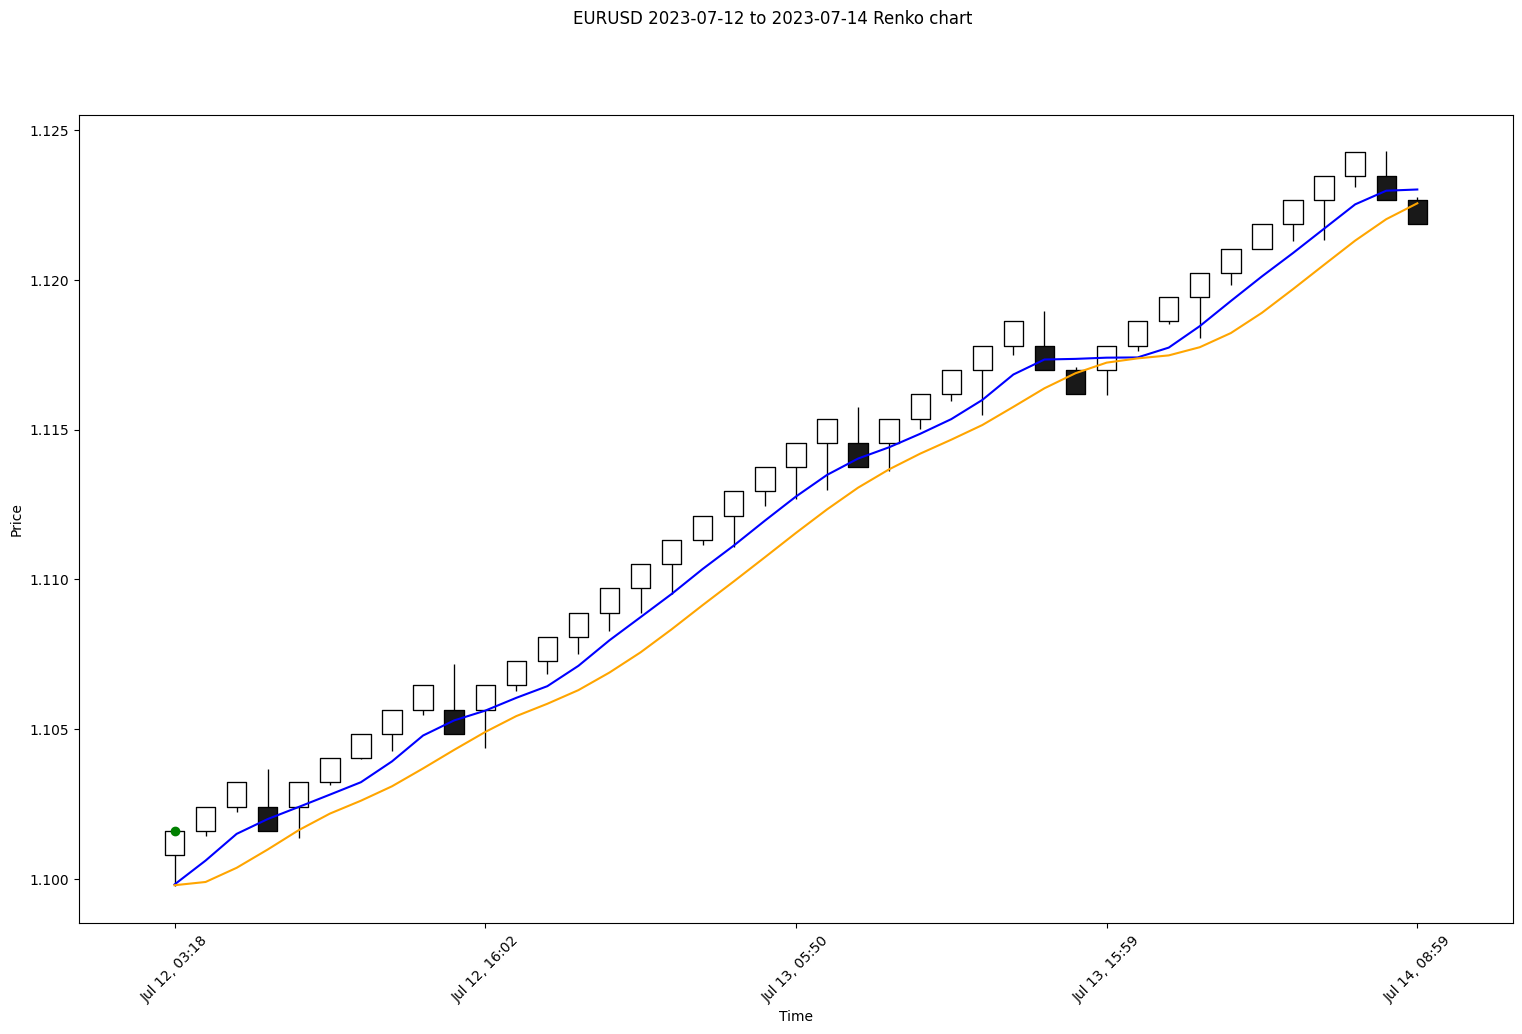

In [709]:
# filter to where the date and time is between 2024-03-07 16:36:00 and 2024.03.08 12:30:00
renko_full_data_259 = renko_full_data.loc[renko_full_data['cum_position_count'] == 582]
# impulse_graph(renko_full_data_259, 'md', 'sb')
# plot the renko chart
fig, ax = plt.subplots()
mplfinance.plot(renko_full_data_259, type='candle', ax=ax, volume=False, show_nontrading=False)
# drop datetime
renko_full_data_259.drop(columns=['datetime'], inplace=True)
renko_full_data_259_reset = renko_full_data_259.reset_index()
# add the sma and smoothing_sma to the chart
ax.plot(renko_full_data_259_reset.index, renko_full_data_259['sma'], label='SMA', color='blue')
ax.plot(renko_full_data_259_reset.index, renko_full_data_259['smoothing_sma'], label='SmoothingSMA', color='orange')
# add a column to renko_full_data_259_reset that copies the close price when sma_crossover is 1 or -1
renko_full_data_259_reset['sma_crossover_price_buy'] = np.where(renko_full_data_259['sma_crossover'] == 1, renko_full_data_259['close'], np.nan)
renko_full_data_259_reset['sma_crossover_price_sell'] = np.where(renko_full_data_259['sma_crossover'] == -1, renko_full_data_259['close'], np.nan)
# add a dot to the chart with the sma_crossover is 1 or -1 and color it green or red
ax.scatter(renko_full_data_259_reset.index, renko_full_data_259_reset['sma_crossover_price_buy'], color='green', marker='o', label='Buy', zorder=5)
ax.scatter(renko_full_data_259_reset.index, renko_full_data_259_reset['sma_crossover_price_sell'], color='red', marker='o', label='Sell', zorder=5)
ax.set_xlabel('Time')
ax.set_ylabel('Price')
# find the date of the first and last index
first_date = renko_full_data_259_reset['datetime'].iloc[0]
last_date = renko_full_data_259_reset['datetime'].iloc[-1]
fig.suptitle(f'EURUSD {first_date.date()} to {last_date.date()} Renko chart')
# increase the size of the chart
fig.set_size_inches(18.5, 10.5)

plt.show()

In [710]:
# filter to just cum_position_count = 3 in renko_full_data
renko_full_data.loc[renko_full_data['cum_position_count'] == 3]

,open,high,low,close,volume,ohlc4,sma,smoothing_sma,sma_diff,sma_sign,...,sma_signal,brick_color,day_of_week,day_of_week_transition,take_profit,stop_loss,position_count,cum_position_count,stop_loss_hit,datetime
datetime,,,,,,,,,,,,,,,,,,,,,
2022-11-15 14:15:25.349,1.04085,1.04095,1.04004,1.04004,1787.0,1.040470,1.041744,1.041845,-0.000101,-1.0,...,sell,red,Tuesday,0,1.03761,1.04247,1,3,0,2022-11-15 14:15:25.349
2022-11-15 15:20:01.809,1.04004,1.04133,1.03923,1.03923,12625.0,1.039957,1.041021,1.041731,-0.000710,-1.0,...,sell,red,Tuesday,0,NaN,1.04247,0,3,0,2022-11-15 15:20:01.809
2022-11-15 15:30:04.374,1.04004,1.04085,1.03920,1.04085,2514.0,1.040235,1.040486,1.041344,-0.000858,-1.0,...,sell,green,Tuesday,0,NaN,1.04247,0,3,0,2022-11-15 15:30:04.374
2022-11-15 15:30:05.830,1.04085,1.04166,1.04085,1.04166,19.0,1.041255,1.040479,1.040933,-0.000453,-1.0,...,sell,green,Tuesday,0,NaN,1.04247,0,3,0,2022-11-15 15:30:05.830


In [711]:
# filter to just cum_position_count = 3 in renko_full_data
renko_full_data.loc[renko_full_data['cum_position_count'] == 70]

,open,high,low,close,volume,ohlc4,sma,smoothing_sma,sma_diff,sma_sign,...,sma_signal,brick_color,day_of_week,day_of_week_transition,take_profit,stop_loss,position_count,cum_position_count,stop_loss_hit,datetime
datetime,,,,,,,,,,,,,,,,,,,,,
2022-11-30 16:17:23.879,1.03842,1.03923,1.03838,1.03923,490.0,1.038815,1.037588,1.037497,0.000091,1.0,...,buy,green,Wednesday,0,1.04166,1.0368,1,70,0,2022-11-30 16:17:23.879
2022-11-30 17:00:22.811,1.03842,1.03998,1.03761,1.03761,11118.0,1.038405,1.038027,1.037553,0.000474,1.0,...,buy,red,Wednesday,0,NaN,1.0368,0,70,0,2022-11-30 17:00:22.811
2022-11-30 17:06:06.152,1.03761,1.03806,1.03680,1.03680,2337.0,1.037317,1.038124,1.037751,0.000372,1.0,...,buy,red,Wednesday,0,NaN,1.0368,0,70,1,2022-11-30 17:06:06.152


## Pyramiding